# Обучение рекуррентных нейронных сетей предсказанию погоды

<h3>Импорт модулей и библиотек</h3>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp2d, LinearNDInterpolator
import csv
import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, TimeDistributed, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
%matplotlib inline

### Конфигурация

**Конфигурация** — совокупность настроек программы, задаваемая пользователем. Изменение этих настроек в соответствии с нуждами пользователя приведет к изменению работы программы.

Данные по всем метеостанциям РФ(координаты, название, номер) - http://esimo.ru/dataview/viewresource?resourceId=RU_RIHMI-WDC_2667
Архивы данных по любой метеостанции за промежуток ~15 лет https://rp5.ru

* **is_train** - переключение режима тренировки. **False** - тренировка не проводится, **True** - проводится.
* **is_debug** - переключение режима обработки файлов с данными. **False** - обработка не применяется, **True** - файлы, скачанные с rp5 предваительно обрабатываются перед использованием для предсказания погоды.
* **is_example** - включает пошаговый пример обучения модели. **False** - показ примера выключен, **True** - включен
* **is_inference** - переключение режима предсказания. **False** - вывод не проводится, **True** - проводится.
* **is_mape** - проверка точности предсказания с использованием Mean absolute percentage error. **False** - проверка не проводится, **True** - проводится.
* **is_interpolation** - переключение режима интерполяции. **False** - интерполяция не проводится, **True** - проводится.
* **is_experiment** - включение эксперимента. **False** - эксперимент не проводится, **True** - проводится. Эксперимент - прогнозирование погоды на территории на которой не проводятся наблюдения с использованием данных с близлежащих метеостанций.
* **columns** - названия функций, которые нужно предсказать
* **csv_dir** - путь к папке с необработанными csv файлами
* **clean_csv_dir** - путь к папке с обработанными csv файлами
* **batch_size** - размер пакета данных
* **sequence_lenght** - длина последовательности значений данных (временного ряда)

In [2]:
is_train = False
is_debug = False
is_example = False
is_inference = False
is_interpolation = False
is_mape = False
is_experiment = True
columns = ['Precipitation','Temperature','Dew Point','Relative Humidity','Sea Level Pressure','Wind Speed']
csv_dir = 'input/prophnet-cvs'
clean_csv_dir = './'
models_dir = 'input/gru-best-w/gru_best_w'
example_csv = 'input/prophnet-cvs/guss_cleane_2013.csv'
batch_size = 64
sequence_lenght = 8 * 30 * 3
# Если один графический процессор, то лучше - во избежание ошибок - его указать
# Если обучение проводится на CPU, то лучше закомментировать
# os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 для 4 gpu

<h3>Импорт набора данных</h3>

Скачанные c [rp5](https://rp5.ru/Погода_в_мире) файлы перед использованием необходимо очистить, потому что они включают в себя много лишней и неполной информации. Для этого мы переберем csv и запишем извлеченные из них данные в новые csv файлы.
Отберем следующие столбцы:
* температура,
* точка росы,
* влажность,
* давление,
* скорость ветра,
* осадки.

Остальные колонки исключим.

In [7]:
if is_debug:
    for file in os.listdir(csv_dir):
        Date_time = []
        Temperature = []
        Dew_Point = []
        Relative_Humidity = []
        Sea_Level_Pressure = []
        Wind_Speed = []
        Precipitation = []
        
        with open(f'{csv_dir}/{file}', "r", encoding='utf-8') as infile:
            reader = csv.reader(infile, delimiter=';', lineterminator='\n')
            next(reader, None)  # пропустить заголовки
            for row in reader:
                if row[0][0]=='#':
                    continue
                elif row[0][0].isalpha():
                    continue 
                else:
                    Date_time.append(row[0])
                    Temperature.append(row[1])
                    Dew_Point.append(row[22])
                    Relative_Humidity.append(row[5])
                    Sea_Level_Pressure.append(row[3])
                    Wind_Speed.append(row[7])
                    if row[23]=='Осадков нет':
                        Precipitation.append(float(0))
                    elif row[23]=='Следы осадков':
                        Precipitation.append(float(0.01))
                    else:
                        Precipitation.append(row[23])

        with open(f"{clean_csv_dir}/cleane_12{file}","w", encoding='utf-8') as outfile:
            writer = csv.writer(outfile, delimiter=',')
            writer.writerow(('Date time', 'Temperature', 'Dew Point', 'Relative Humidity','Sea Level Pressure', 'Wind Speed', 'Precipitation'))
            for i in range(len(Date_time)):
                time = Date_time[i]
                temperature = Temperature[i]
                dew_point = Dew_Point[i]
                humidity = Relative_Humidity[i]
                pressure = Sea_Level_Pressure[i]
                wind = Wind_Speed[i]
                precipitation = Precipitation[i]
                
                writer.writerow([time]+[temperature]+[dew_point]+[humidity]+[pressure]+[wind]+[precipitation])

### Обучение модели на всех функциях датасета сразу

Откроем один файл с помощью библиотеки pandas для примера. Установим столбец с названием 'Date time' в качестве индекса.

In [ ]:
if is_example:
    try:
        dataset = pd.read_csv(example_csv, parse_dates = ['Date time'])
        dataset = dataset.set_index('Date time')
    except:
        print('Укажите путь к файлу')

<h3>Отсутствующие данные и их обработка</h3>

In [26]:
if is_example:
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49520 entries, 2022-03-20 23:00:00 to 2005-11-03 02:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         49483 non-null  float64
 1   Dew Point           49452 non-null  float64
 2   Relative Humidity   49413 non-null  float64
 3   Sea Level Pressure  49430 non-null  float64
 4   Wind Speed          47810 non-null  float64
 5   Precipitation       10122 non-null  float64
dtypes: float64(6)
memory usage: 2.6 MB


Мы видим, что в некоторых столбцах пропущенны значения. Нужно решить, как можно заполнить пропуски в столбцах "Wind Speed", "Precipitation", "Sea Level Pressure". Для этого воспользуемся описанием датафрейма, и обработаем датасет, уберем пропущенные значения.

In [27]:
if is_example:
    print(dataset.describe().transpose())

                      count        mean        std    min    25%     50%  \
Temperature         49483.0    3.267462  14.466129  -40.7   -7.4    4.10   
Dew Point           49452.0   -2.451953  12.317369  -77.7  -10.8   -1.20   
Relative Humidity   49413.0   70.565175  19.415804    0.0   58.0   75.00   
Sea Level Pressure  49430.0  763.290316   8.801977  719.6  757.2  762.50   
Wind Speed          47810.0    3.107049   2.175518    0.0    2.0    3.00   
Precipitation       10122.0    0.834138   3.689373    0.0    0.0    0.01   

                      75%    max  
Temperature          14.8   38.1  
Dew Point             7.4   28.5  
Relative Humidity    85.0  123.0  
Sea Level Pressure  768.8  801.5  
Wind Speed            4.0   47.0  
Precipitation         0.5  203.0  


In [3]:
def clearing_dataset(data):
    # Пропущенную температуру заполним предыдущим значением
    data['Temperature'].fillna(method='bfill', inplace=True)
    # Аналогично поступисм с точкой росы
    data['Dew Point'].fillna(method='bfill', inplace=True)
    # И отностиельной влажностью
    data['Relative Humidity'].fillna(method='bfill', inplace=True)
    # Пропущенные осадки заполним последующим значением, потому что измерение производится в определенный отрезок времени (12 - 18 часов) (см. необработанный файл)
    data['Precipitation'].fillna(method='ffill', inplace=True)
    # Могут остаться необработанные ячейки, если нет последующего значени (начало фрейма) - заполним их предыдущим значением
    data['Precipitation'].fillna(method='bfill', inplace=True)
    # dataset['Precipitation'].fillna(method='ffill', inplace=True)
    # Могут быть моменты, когда ветра нет. Поэтому в пропущенные значения вставляем 0.1
    data['Wind Speed'].fillna(0.1, inplace=True) #(0, inplace=True)
    # Значение давления меняется от 967.60 до 1057.20, стандатрное отклонение составляет 11.184571. 
    # поэтому данные пропуски можно заполнить средним или же медианным значением
    data['Sea Level Pressure'].fillna(data['Sea Level Pressure'].median(), inplace=True)
    return data

In [4]:
def adjustment(data):
    # Заменим нули близким значением на выбор
    data = data.replace({'Precipitation': {0.0 : 0.1}, 'Temperature': {0.0 : 0.1}, 'Dew Point': {0.0 : 0.1}, 'Wind Speed': {0.0 : 1.0}, 
                           'Relative Humidity': {0.0 : 0.1}, 'Sea Level Pressure': {0.0 : 0.1}})
    return data

In [30]:
if is_example:
    dataset = clearing_dataset(dataset)
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49520 entries, 2022-03-20 23:00:00 to 2005-11-03 02:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         49520 non-null  float64
 1   Dew Point           49520 non-null  float64
 2   Relative Humidity   49520 non-null  float64
 3   Sea Level Pressure  49520 non-null  float64
 4   Wind Speed          49520 non-null  float64
 5   Precipitation       49520 non-null  float64
dtypes: float64(6)
memory usage: 2.6 MB


In [31]:
if is_example:
    print('Shape of the Dataset is: {}'.format(dataset.shape))
    print(dataset.head(5))

Shape of the Dataset is: (49520, 6)
                     Temperature  Dew Point  Relative Humidity  \
Date time                                                        
2022-03-20 23:00:00         -7.0       -9.0               86.0   
2022-03-20 20:00:00         -5.9       -9.0               79.0   
2022-03-20 17:00:00         -3.9       -9.1               68.0   
2022-03-20 14:00:00         -5.1      -10.7               65.0   
2022-03-20 11:00:00        -10.1      -14.2               72.0   

                     Sea Level Pressure  Wind Speed  Precipitation  
Date time                                                           
2022-03-20 23:00:00               755.5         2.0            0.0  
2022-03-20 20:00:00               757.3         4.0            0.0  
2022-03-20 17:00:00               759.3         5.0            0.0  
2022-03-20 14:00:00               761.8         3.0            0.0  
2022-03-20 11:00:00               764.8         4.0            0.0  


<b>Функции построения графика для определения отсутствующих данных и выбросов вручную</b></br>
<p>Можно использовать другие методы, например ECDF, Statistical Analysts и т. д.</p>

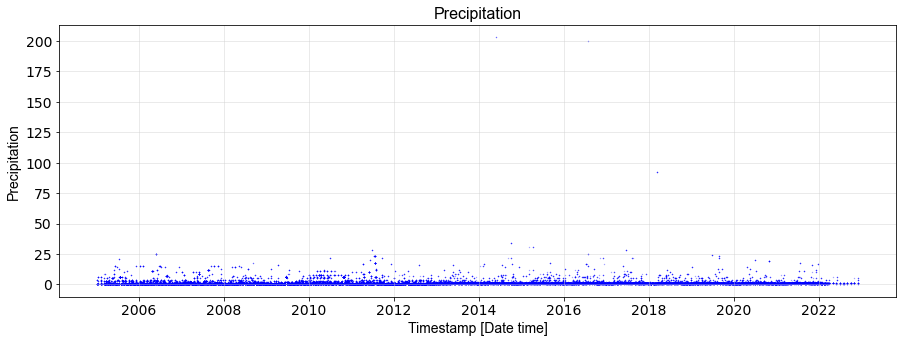

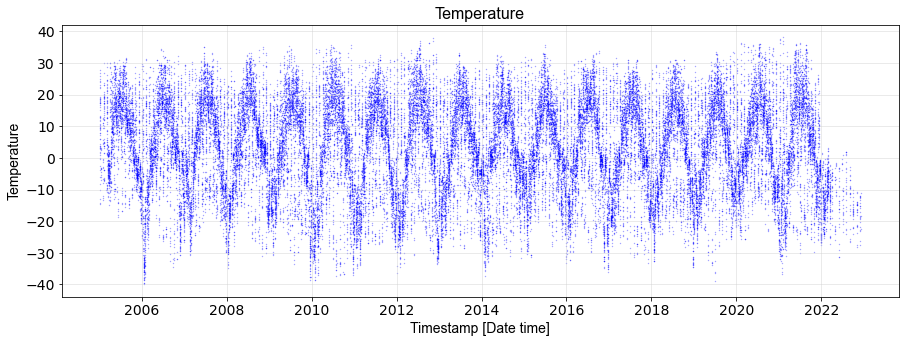

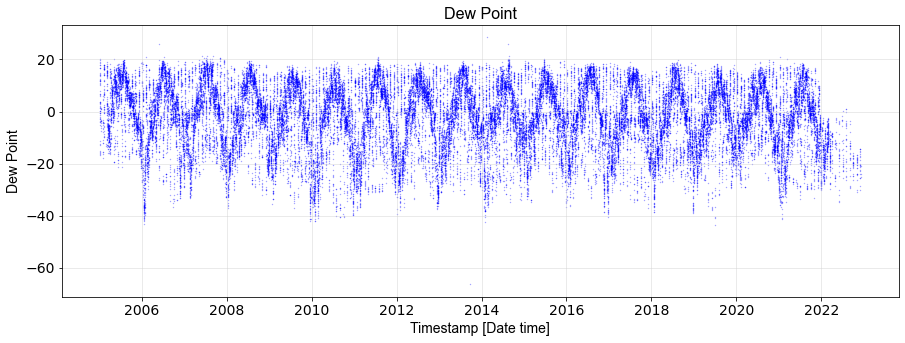

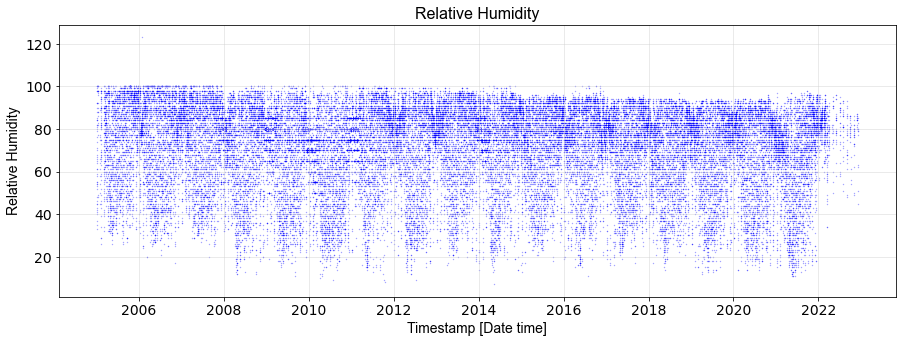

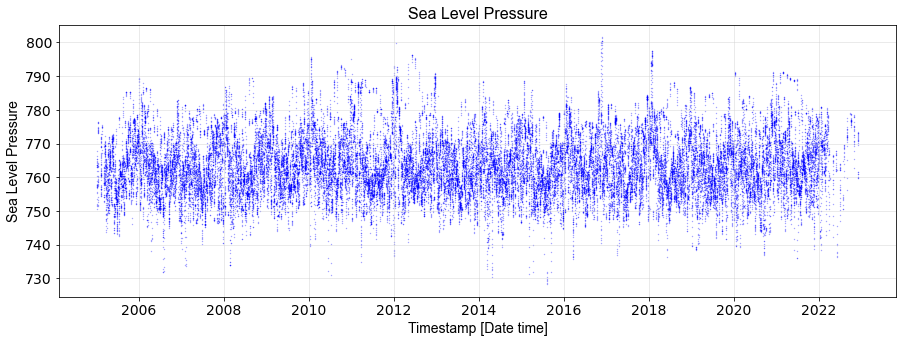

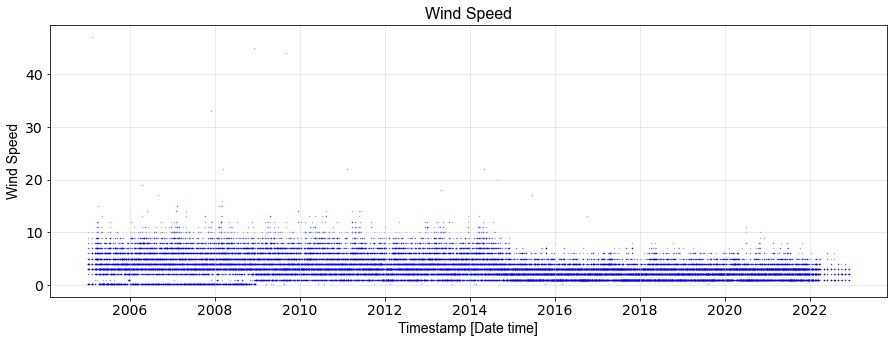

In [32]:
# Простая функция для построения любого объекта из набора данных на заданной временной шкале.
def plot_time_series(dataset, feature_name):
    _ = plt.rcParams['figure.figsize'] = (15, 5)
    _ = plt.grid(which = 'major', c = '#cccccc', alpha = 0.5)
    _ = plt.scatter(dataset.index, dataset[feature_name],
                    marker = 'o', s = 0.1, alpha = 0.5,
                    color = 'blue')
    _ = plt.title(feature_name, family = 'Arial', fontsize = 16)
    _ = plt.xlabel('Timestamp [Date time]', family = 'Arial', fontsize = 14)
    _ = plt.ylabel(feature_name, family = 'Arial', fontsize = 14)
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(fontsize = 14)
    _ = plt.show()
                  
    return None

# Простой способ удалить выбросы данных
def removeOutliers(dataset, feature_name):
    data_temp = dataset[feature_name]
    
    d_min = np.min(data_temp)
    d_mean = np.mean(data_temp)
    
    data_temp = data_temp.replace(d_min, d_mean)
    dataset[feature_name] = data_temp
    
    return dataset

if is_example:
    # Удалить выбросы данных ()
    dataset = removeOutliers(dataset, 'Temperature')
    dataset = removeOutliers(dataset, 'Dew Point')
    dataset = removeOutliers(dataset, 'Precipitation')
    dataset = removeOutliers(dataset, 'Wind Speed')
    dataset = removeOutliers(dataset, 'Sea Level Pressure')
    dataset = removeOutliers(dataset, 'Relative Humidity')

    # Отображение всех функций на временной шкале
    for feature in columns:
        plot_time_series(dataset, feature)

Выведем тепловую карту, которая покажет кореляцию между параметрами.

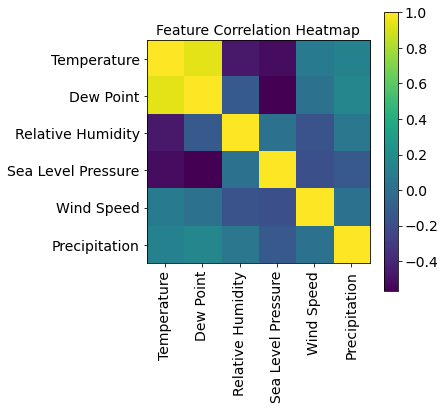

In [21]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

if is_example:
    show_heatmap(dataset)

На тепловой карте видно, что температура хорошо коррелирует с точкой росы, а все остальные параметры практически никак не зависят друг от друга. 

<h3>Целевые данные для прогнозирования</h3><p>Мы будем прогнозировать эти сигналы.</p>

In [22]:
if is_example:
    # Составим список функций, которые будем предсказывать
    target_features = ['Precipitation', 'Dew Point', 'Relative Humidity','Sea Level Pressure', 'Wind Speed', 'Temperature']
    print('We will predict {} features.'.format(len(target_features)))

We will predict 6 features.


Ниже приведен номер временного шага, на который мы будем сдвигать целевые данные. Наш набор данных пополняется **каждые 3 часа**, поэтому **имеется 8 наблюдений за 24 часа**.

Если мы хотим предсказать погоду на **24 часа вперед**, мы сдвигаем данные **на 8 временных шага**. Если мы хотим предсказать погоду **на 7 дней вперед**,
мы сдвигаем **7 × 8 = 56 временных шагов**, а если только **на 3 часа**, то **на 1 шаг**.

In [23]:
if is_example:
    shift_days = 7
    shift_steps = shift_days * 8

<p>Создадим новый фрейм со сдвинутыми во времени данными.</p><p><b><i>Примечание! (по поводу неправильного сдвига во времени)</i></b> Данные необходимо перемещать в <b>правом</b> направлении (прогнозирование в будущее, а не в прошлое).</p>

In [24]:
if is_example:
    df_targets = dataset[target_features].shift(-shift_steps)
    print(df_targets.head(5))

                     Precipitation  Dew Point  Relative Humidity  \
Date time                                                          
2022-03-20 23:00:00       0.862196      -19.1               78.0   
2022-03-20 20:00:00       0.010000      -17.2               74.0   
2022-03-20 17:00:00       0.010000      -16.5               58.0   
2022-03-20 14:00:00       0.010000      -17.7               55.0   
2022-03-20 11:00:00       0.010000      -21.3               67.0   

                     Sea Level Pressure  Wind Speed  Temperature  
Date time                                                         
2022-03-20 23:00:00               769.0         1.0        -16.1  
2022-03-20 20:00:00               768.4         1.0        -13.5  
2022-03-20 17:00:00               767.9         2.0         -9.6  
2022-03-20 14:00:00               767.8         3.0        -10.4  
2022-03-20 11:00:00               768.4         2.0        -16.6  


In [25]:
if is_example:
    # Проверка переключения
    print(dataset[target_features].head(shift_steps + 5))

                     Precipitation  Dew Point  Relative Humidity  \
Date time                                                          
2022-03-20 23:00:00       0.862196       -9.0               86.0   
2022-03-20 20:00:00       0.862196       -9.0               79.0   
2022-03-20 17:00:00       0.862196       -9.1               68.0   
2022-03-20 14:00:00       0.862196      -10.7               65.0   
2022-03-20 11:00:00       0.862196      -14.2               72.0   
...                            ...        ...                ...   
2022-03-13 23:00:00       0.862196      -19.1               78.0   
2022-03-13 20:00:00       0.010000      -17.2               74.0   
2022-03-13 17:00:00       0.010000      -16.5               58.0   
2022-03-13 14:00:00       0.010000      -17.7               55.0   
2022-03-13 11:00:00       0.010000      -21.3               67.0   

                     Sea Level Pressure  Wind Speed  Temperature  
Date time                                       

<p>Фрейм данных со сдвигом во времени имеет ту же длину, что и исходный кадр данных, но последние наблюдения имеют значение <code>NaN</code> (не число).</p>

In [26]:
if is_example:
    print(df_targets.tail())

                     Precipitation  Dew Point  Relative Humidity  \
Date time                                                          
2005-11-03 14:00:00            NaN        NaN                NaN   
2005-11-03 11:00:00            NaN        NaN                NaN   
2005-11-03 08:00:00            NaN        NaN                NaN   
2005-11-03 05:00:00            NaN        NaN                NaN   
2005-11-03 02:00:00            NaN        NaN                NaN   

                     Sea Level Pressure  Wind Speed  Temperature  
Date time                                                         
2005-11-03 14:00:00                 NaN         NaN          NaN  
2005-11-03 11:00:00                 NaN         NaN          NaN  
2005-11-03 08:00:00                 NaN         NaN          NaN  
2005-11-03 05:00:00                 NaN         NaN          NaN  
2005-11-03 02:00:00                 NaN         NaN          NaN  


<h3>Реализация сдвигов в кадре данных (массивы NumPy)</h3>

<p>Теперь мы преобразуем фрейм данных Pandas в массивы NumPy, которые можно вводить в нейронную сеть. Мы также удаляем последнюю часть массивов, потому что целевые данные имеют значение NaN для сдвинутого периода, а нам нужны только действительные данные одинаковой формы для входных и выходных временных рядов.</р></br>

In [27]:
if is_example:    
    x_data = dataset.values[0:-shift_steps]
    print(type(x_data))
    print('Shape: {}'.format(x_data.shape))

<class 'numpy.ndarray'>
Shape: (49464, 6)


<p>Это <b>выходные сигналы</b> (или <b>целевые сигналы</b>).</p>

In [28]:
if is_example:
    y_data = df_targets.values[:-shift_steps]
    print('Shape: {}'.format(y_data.shape))

Shape: (49464, 6)


In [29]:
if is_example:   
    # Количество наблюдений
    num_data = len(x_data)
    print(num_data)

49464


<h3>Создание набора для обучения и набора тестов</h3>

<b>TRAINING SET:</b>

In [30]:
if is_example:
    # Выберем число на которое умножим общее количество строк датафрейма, чтобы разделить датафрейм на тренировочную и валидационную часть
    train_split = 0.9
    # Длина тренировочного набора
    num_train = int(train_split * num_data)
    print('Training set lenght: {} observations.'.format(num_train))

Training set lenght: 44517 observations.


<p>Входные сигналы для обучающего набора:</p>

<b>TEST SET:</b>

In [31]:
if is_example:    
    # Длина тестового набора
    num_test = num_data - num_train
    print('Test set lenght: {} observations.'.format(num_test))

Test set lenght: 4947 observations.


Входные сигналы для обучающего набора и тестового набора:

In [32]:
if is_example:
    x_train = x_data[0:num_train]
    x_test = x_data[num_train:]
    print(len(x_train) + len(x_test))

49464


In [33]:
if is_example:    
    y_train = y_data[0:num_train]
    y_test = y_data[num_train:]
    print(len(y_train) + len(y_test))

49464


<p>Количество входных сигналов:</p>

In [34]:
if is_example:
    num_x_signals = x_data.shape[1]
    print(num_x_signals)

6


<p>Количество выходных сигналов:</p>

In [35]:
if is_example:
    num_y_signals = y_data.shape[1]
    print(num_y_signals)

6


<h3>Масштабирование данных</h3><p>Данные содержат широкий диапазон значений, поэтому их необходимо масштабировать для выполнения модели машинного обучения.</p>

In [36]:
if is_example:
    print('Min value: {}'.format(np.min(x_train)))
    print('Max value: {}'.format(np.max(x_train)))

Min value: -66.4
Max value: 801.5


Нейронная сеть лучше всего работает со значениями, которые варьируются **от -1 до 1**, или **от 0 до 1** в зависимости от задачи и функции активации. Поэтому нам нужно масштабировать данные, прежде чем они будут введены в ИНС. Для этого мы можем использовать scikit-learn.
Считается, что:

* Dense(1, activation='softmax') - не подходит для решения задач регрессии, обычно зависает и ничего не узнает.
* Dense(1, activation='relu') - не всегда хорошо работает в задачах предсказания, очень вероятно ничего не узнает.
* Dense(1, activation='sigmoid') - идеально подходит для задач классификации (бинарных) и в некоторой степени хорош для регрессии со значениями от 0 до 1.
* Dense(1, activation='tanh') - хорошо подходит для регрессии со значениями от -1 до 1.
* Dense(1, activation='softplus') - хорошо подходит для регрессии со значениями от 0 до + бесконечность.
* Dense(1, actiavation='linear') - хорош для регрессии в целом без ограничений (но настоятельно рекомендуется предварительно нормализовать данные).

Выберем **activation='softplus'** и маштабируем данные до диапазона **(0.1,0.9)**.
(Я еще пробовала activation='linear', тогда масштабируем данные до диапазона (-1,1))

In [37]:
if is_example:
    # Определяем объект Scaler
    x_scaler = MinMaxScaler(feature_range=(0.1, 0.9))

In [38]:
if is_example:   
    # Масштабируем тренировочные данные
    x_train_scaled = x_scaler.fit_transform(x_train)

<p>Помимо небольшой ошибки округления, масштабированные данные устанавливаются между <code>0.1</code> и <code>0.9</code>.</p>

In [39]:
if is_example:
    print('Min value {}'.format(np.min(x_train_scaled)))
    print('Max value {}'.format(np.max(x_train_scaled)))

Min value 0.09999999999999964
Max value 0.9000000000000001


In [40]:
if is_example:    
    # Масштабируем тестовые данные
    x_test_scaled = x_scaler.transform(x_test)

Входные и выходные массивы могут иметь разные диапазоны значений. Чтобы избежать ошибки, для у значений создадим отдельный Scaler.

In [41]:
if is_example:    
    y_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

<h3>Генератор данных</h3>
<p>Набор данных теперь подготовлен как двумерный массив Numpy.

In [42]:
if is_example:    
    print(x_train_scaled.shape)
    print(y_train_scaled.shape)

(44517, 6)
(44517, 6)


In [43]:
if is_example:    
    print(x_test_scaled.shape)
    print(y_test_scaled.shape)

(4947, 6)
(4947, 6)


<p>Вместо обучения рекуррентной нейронной сети на рядах наблюдений мы будем использовать следующую функцию для создания пакета более коротких подпоследовательностей, выбранных случайным образом из обучающих данных.</p>

In [5]:
def batch_generator(batch_size, sequence_lenght, num_tr, x_signals, y_signals, x_scaled, y_scaled):
    """
    Функция генератора для создания случайных пакетов обучающих данных
    """
    while True:
        # Выделите новый массив для пакета входных сигналов.
        x_shape = (batch_size, sequence_lenght, x_signals)
        x_batch = np.zeros(shape = x_shape, dtype = np.float16)
        
        # Выделить новый массив для пакета выходных сигналов.
        y_shape = (batch_size, sequence_lenght, y_signals)
        y_batch = np.zeros(shape = y_shape, dtype = np.float16)
        
        # Заполнить пакет случайными последовательностями данных.
        for i in range(batch_size):
            # Получить случайный начальный индекс
            # Это указывает где-то на обучающие данные.
            idx = np.random.randint(num_tr - sequence_lenght)
            
            # Копируем последовательность данных, начиная с этого индекса.
            x_batch[i] = x_scaled[idx : idx + sequence_lenght]
            y_batch[i] = y_scaled[idx : idx + sequence_lenght]
            
        yield(x_batch, y_batch)
#         yield [x_batch, y_batch] # Если возникнет ошибка, возникающая в более старых версиях Keras

<p>Я буду использовать довольно большой размер пакета (смотреть конфигурацию), чтобы нагрузка на GPU была близка к 100 % (данная модель и на CPU обучается достаточно быстро).</p>

<p>Мы будем использовать длину последовательности <b>720</b>  (смотреть конфигурацию). Один временной шаг соответствует 3 часам, поэтому <code>8</code> соответствует 1 дню, а <code>8×10</code> соответствует 10 дням.</p>

In [45]:
print('Sequence lenght is {} observations.'.format(sequence_lenght))

Sequence lenght is 720 observations.


<p>Создание батч генератора.</p>

In [46]:
if is_example:
    generator = batch_generator(batch_size = batch_size,
                            sequence_lenght = sequence_lenght,
                            num_tr = num_train,
                            x_signals = num_x_signals,
                            y_signals = num_y_signals,
                            x_scaled = x_train_scaled, 
                            y_scaled = y_train_scaled)

#### Тестирование пакетного генератора на работоспособность.

<p>Батч генератор выдает случайную партию из <code>batch_size = <b>64</b></code> последовательностей, каждая из которых имеет <code>8 × 30 × 3 = <b>720</ b></code> шагов, а шаг состоит из <code>6</code> входных сигналов и <code>6</code> выходных сигналов.</p>

In [47]:
if is_example:
    x_batch, y_batch = next(generator)

In [48]:
if is_example:    
    print(x_batch.shape)
    print(y_batch.shape)

(64, 720, 6)
(64, 720, 6)


<p>В качестве примера мы можем построить один из 6 входных сигналов.</p>

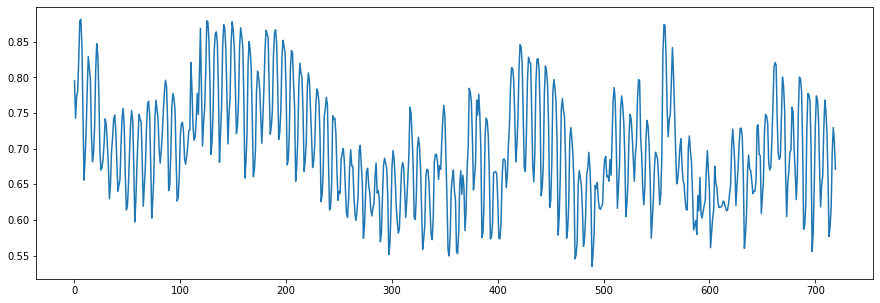

In [49]:
if is_example:    
    batch = 0  # Первая последовательность в пакете
    signal = 0 # Первый сигнал из 14 входных сигналов

    seq = x_batch[batch, :, signal]
    plt.plot(seq)

<p>Мы также можем построить график одного из выходных сигналов.</p>

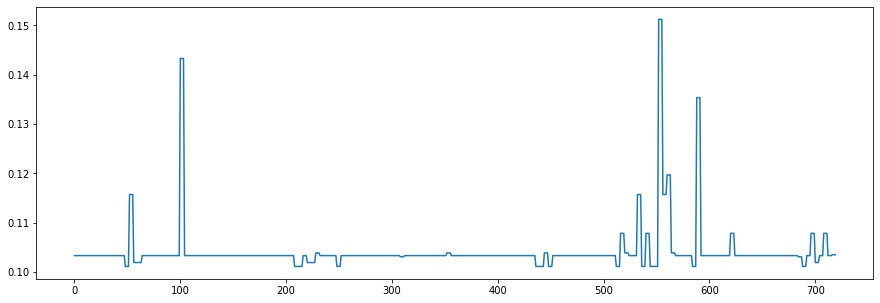

In [50]:
if is_example:    
    seq = y_batch[batch, :, signal]
    plt.plot(seq)

<h3>Validation Set</h3>

<p>Батч генератор случайным образом выбирает набор последовательностей из обучающих данных и использует их во время обучения. Валидационные данные мы будем загружать по порядку.

In [51]:
if is_example:    
    validation_data = (np.expand_dims(x_test_scaled, axis = 0),
                       np.expand_dims(y_test_scaled, axis = 0))
    # Функция expand_dims () используется для расширения формы массива, вставляя новую ось.

    print(validation_data)
    print('The lenght of Validation Data: {}'.format(len(validation_data[0][0])))

(array([[[0.51508453, 0.65721812, 0.81397849, 0.37612551, 0.18730512,
         0.1       ],
        [0.5046814 , 0.65553214, 0.8655914 , 0.36193724, 0.18730512,
         0.10114291],
        [0.50052016, 0.65131718, 0.85698925, 0.35102319, 0.20512249,
         0.10114291],
        ...,
        [0.42561769, 0.58303477, 0.79677419, 0.40995907, 0.15167038,
         0.10271935],
        [0.44330299, 0.6032666 , 0.83978495, 0.43069577, 0.13385301,
         0.10271935],
        [0.44226268, 0.60410959, 0.85698925, 0.45252387, 0.13385301,
         0.10271935]]]), array([[[0.10153702, 0.43972603, 0.65913978, 0.63260573, 0.16948775,
         0.26957087],
        [0.10153702, 0.41865121, 0.68494624, 0.646794  , 0.15167038,
         0.23836151],
        [0.10153702, 0.3967334 , 0.71075269, 0.6478854 , 0.1       ,
         0.20611183],
        ...,
        [0.11572491, 0.62855638, 0.80537634, 0.3728513 , 0.25857461,
         0.48179454],
        [0.11572491, 0.63024236, 0.87419355, 0.31500682, 0.2

<h2>Создание рекуррентной нейронной сети</h2>
<p>Теперь мы готовы создать рекуррентную нейронную сеть (RNN). Для этого мы будем использовать <i>Keras API</i> из-за его простоты.</p>
<p><b>RNN</b> - это сети, которые обычно используются в случае, когда входные или выходные данные представляют из себя последовательность элементов, упорядоченных по времени.</p>
<p><b>LSTM</b> – особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям.</p></b>
<p><b>GRU</b> - можно рассматривать как более простую версию сетей долгой краткосрочной памяти LSTM. Она включает в себя много схожих понятий, но имеет куда меньше параметров, а потому при одном и том же размере скрытого слоя обучается быстрее. Эта модель превосходит по производительности <b>LSTM</b> в некоторых задачах.</p></br>

Sequential группирует линейный набор слоев в файл tf.keras.Model.

In [52]:
if is_example:
    model = Sequential()

<p>Теперь мы можем добавить Gated Recurrent Unit (GRU) или LSTM в сеть. Для начала выберем сеть с 64 ядрами.</p></b>
<p>Нужно обратить внимание: поскольку это первый слой в модели, Keras необходимо знать форму своих входных данных. У нас они представляют собой набор последовательностей произвольной длины, потому мы передаем <code>None</code> в первый слой,
где каждое наблюдение имеет ряд входных сигналов (<code>num_x_signals</code>).</p>

In [53]:
if is_example:
    print(num_y_signals)

6


In [54]:
if is_example:
    model.add(GRU(units = 64, # 128, 256, 512
                  return_sequences = True,
                  input_shape = (None, num_x_signals,)))

    # model.add(LSTM(64, return_sequences = True, input_shape = (None, num_x_signals,)))

<p><i>GRU</i> выводит пакет последовательностей из <b>720</b> значений. Выходные сигналы в наборе данных были ограничены между <code>0.1</code> и <code>0.9</code> (или -1 и 1) с помощью MinMaxScaler.</p> Для обработки выходных данных из RNN мы можем применить обычный полносвязный слой с активацией softplus или sigmoid, или linear.

In [55]:
if is_example:
    # model.add(TimeDistributed(Dense(num_y_signals, activation='softplus'))) #activation = 'sigmoid')) #activation='softplus'))
    model.add(Dense(num_y_signals, activation = 'sigmoid')) #activation = 'sigmoid')) #activation='linear')) activation='softplus'))

<p>Проблема с использованием функции активации Sigmoid заключается в том, что она выводит значения только в том же диапазоне, что и обучающие данные.</p></br>
<p>Вместо нее мы можем использовать линейную функцию активации на выходе.
Это позволит выходу принимать произвольные значения, что может сработать со стандартной инициализацией для простой сетевой архитектуры, но для более крупных моделей, например с большим количеством слоев, может потребоваться инициализировать веса меньшими значениями, чтобы избежать значений <code>NaN</code> во время обучения.</p>

<h3>Функция потерь</h3></br>
<p>Мы будем использовать среднеквадратичную ошибку (<b>MSE</b>) в качестве функции потерь, которую минимизируем. Она измеряет, насколько точно выходные данные модели соответствуют истинным выходным сигналам.</p></br>
<p>Использование значения потерь для ранних временных шагов может привести к тому, что модель в последующем будет работать хуже. Определим для модели <i>период прогрева</i>, равный 50 временным шагам, в этот период не будет вычисляться точность в функции потерь, с надеждой повысить точность для более поздних временных шагов.</p >

In [6]:
warmup_steps = 50

In [7]:
def loss_mse_warmup(y_true, y_pred):
    """
    Рассчитайте среднеквадратичную ошибку между y_true и y_pred,
    но игнорируйте начальную «разогревочную» часть последовательностей.
    
    y_true : желаемый результат.
    y_pred : выходные данные модели.
    """
    
    # Форма обоих входных тензоров:
    # [batch_size, sequence_lenght, num_y_signals].
    
    # Игнорируем «разогревающие» части последовательностей, взяв срезы тензоров.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    
    # Эти нарезанные тензоры имеют следующую форму:
    # [batch_size, sequence_lenght - warmup_steps, num_y_signals]
    
    # Рассчитать потери MSE для каждого значения в этих тензорах.
    loss = tf.losses.mean_squared_error(y_true_slice, y_pred_slice)
    
    # Чтобы избежать ошибки в расчетах, вычисляет среднее значение элементов loss.
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

<h3>Скомпилировать модель</h3>
<p>Определим оптимизатор и начальную скорость обучения, затем скомпилируем модель Keras.</p></p>

In [12]:
if is_example:  
    optimizer = RMSprop(learning_rate = 1e-3) # Adam(learning_rate = 1e-3)
    model.compile(loss = loss_mse_warmup, optimizer = optimizer) #loss_mse_warmup # ['mse']

<p>Это очень маленькая модель с одним рекуррентным слоем. Цифра 6 полносвязного слоя соответствует целевым сигналам, которые мы хотим предсказать (смотреть target_features (от 1 до 6)).</p>

In [59]:
if is_example:
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 64)          13824     
_________________________________________________________________
dense (Dense)                (None, None, 6)           390       
Total params: 14,214
Trainable params: 14,214
Non-trainable params: 0
_________________________________________________________________


<h3>Функции обратного вызова</h3>
<p>Во время обучения мы будем сохранять контрольные точки, если валидационный лосс будет меньше всех предыдущих. Вот обратный вызов для записи контрольных точек во время обучения.</p>

In [60]:
if is_example:    
    path_checkpoint = './lstm_v1.h5'
    callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                          monitor = 'val_loss',
                                          verbose = 1,
                                          save_weights_only = True,
                                          save_best_only = True)

<p>Теперь обратный вызов для остановки обучения после того, как модель пять раз подряд не сможет улучшить показатели обучения.</p>

In [61]:
if is_example:
    callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                            patience = 5,
                                            verbose = 1)

Последний обратный вызов уменьшает скорость обучения, когда метрика перестает улучшаться.

In [62]:
if is_example:    
    callback_reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                           factor = 0.1,
                                           min_lr = 1e-4,
                                           patience = 0,
                                           verbose = 1)

In [63]:
if is_example:
    callbacks = [callback_early_stopping,
                 callback_checkpoint,
                 callback_reduce_lr]

<h2>Обучение рекуррентной нейронной сети</h2>
<p>Сейчас самое время обучить нейронную сеть.</p></br>
<p><b>steps_per_epoch = total_samples/batch_size или меньшее число</b> (если нет неоходимости или возможности использовать все данные) - количество шагов (загрузок батчей данных), после совершения которых эпоха завершается.</p></br>


In [64]:
if is_example:
    print(x_train_scaled.shape)
    print(y_train_scaled.shape)

(44517, 6)
(44517, 6)


In [65]:
if is_example:
    # model.fit_generator(generator = generator,
    #                     epochs = 200,
    #                     steps_per_epoch = 248, #25, #modified : 100
    #                     validation_data = validation_data,
    #                     callbacks = callbacks)
    model.fit(generator,
                        epochs = 200,
                        steps_per_epoch = 248, #25, #modified : 100
                        validation_data = validation_data,
                        callbacks = callbacks)

Epoch 1/200
248/248 [==============================] - 160s 631ms/step - loss: 0.0095 - val_loss: 0.0069

Epoch 00001: val_loss improved from inf to 0.00688, saving model to .\lstm_v1.h5
Epoch 2/200
248/248 [==============================] - 154s 622ms/step - loss: 0.0061 - val_loss: 0.0066

Epoch 00002: val_loss improved from 0.00688 to 0.00661, saving model to .\lstm_v1.h5
Epoch 3/200
248/248 [==============================] - 154s 622ms/step - loss: 0.0056 - val_loss: 0.0061

Epoch 00003: val_loss improved from 0.00661 to 0.00611, saving model to .\lstm_v1.h5
Epoch 4/200
248/248 [==============================] - 153s 616ms/step - loss: 0.0054 - val_loss: 0.0061

Epoch 00004: val_loss did not improve from 0.00611

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/200
248/248 [==============================] - 153s 616ms/step - loss: 0.0052 - val_loss: 0.0060

Epoch 00005: val_loss improved from 0.00611 to 0.00597, saving model to .\lstm_v1.h5
E

<h3>Загрузить контрольную точку</h3>
<p>Так как обучение могло быть остановлено из-за ухудшения результатов в последние перед остановкой эпохи, загрузим контрольную точку, которая была сохранена потому что имела лучшие показатели после валидации.</p>

In [66]:
if is_example:
    try:
        model.load_weights(path_checkpoint)
    except Exception as error:
        print('Error trying to load checkpoint.\n{}'.format(error))

<h2>Производительность на тестовом наборе</h2>
<p>Теперь мы можем оценить производительность загруженной модели на тестовом наборе и создадим пакет с одной последовательностью.</p>

In [67]:
if is_example:
    result = model.evaluate(x = np.expand_dims(x_test_scaled, axis = 0),
                            y = np.expand_dims(y_test_scaled, axis = 0))

1/1 [==============================] - 0s 378ms/step - loss: 0.0060


In [68]:
if is_example:
    print('Loss (test-set): {}'.format(result))

Loss (test-set): 0.005973110906779766


<h2>Общие прогнозы</h2>
<p>Эта вспомогательная функция отображает прогнозируемые и истинные выходные сигналы.</p>

In [8]:
def plot_comparison(start_idx, lenght = 100, train = True):
    """
    Построение графика-сравнение предсказанных и истинных значений.
    
    Параметры:
        > start_idx: начальный индекс для временного ряда
        > lenght: длина последовательности для обработки и построения графика
        > train: логическое значение, использовать ли обучение или тест-тест.
    """
    
    if train:
        # Использовать обучающие данные
        x = x_train_scaled
        y_true = y_train
    
    else:
        # Использовать тестовые данные
        x = x_test_scaled
        y_true = y_test
        
    # Конечный индекс последовательностей
    end_idx = start_idx + lenght
    
    # Выберите последовательности из заданного диапазона.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Входные сигналы для модели.
    x = np.expand_dims(x, axis = 0)
    
    # Предсказание выходных сигналов.
    y_pred = model.predict(x)
    
    # Результат модели находится между 0 и 1.
    # Масштабирование прогноза обратно до исходного формата
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # Расчитаем показатели регрессионных метрик для предсказаний модели
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    a = mape(np.float32(y_true), np.float32(y_pred_rescaled))
    mae = tf.keras.metrics.MeanAbsoluteError()
    b = mae(np.float32(y_true), np.float32(y_pred_rescaled))
    rmse = tf.keras.metrics.RootMeanSquaredError()
    c = rmse(np.float32(y_true), np.float32(y_pred_rescaled))
    print('MAPE:', float(a))
    print('MAE:', float(b))
    print('RMSE:', float(c))
    
    for signal in range(len(target_features)):
        # Для каждой функции
        # Получение выходного сигнала, предсказанного моделью.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Получение истинного выходного сигнала из набора данных
        signal_true = y_true[:, signal]
        
        plt.figure(figsize = (15, 5))
        
        # Построение графика.
        plt.plot(signal_true, label = 'True', color = 'green')
        plt.plot(signal_pred, label = 'Pred.', color = 'blue')
        
        # Серый прямоугольник для периода прогрева.
        p = plt.axvspan(0, warmup_steps, facecolor = 'black', alpha = 0.15)
        
        # Нанесение меток.
        plt.ylabel(target_features[signal], fontsize = 14)
        plt.legend(loc = 'best', shadow = True)
        plt.show()
        
    return None

<h3>Пример из набора тестов</h3>
<p>Теперь рассмотрим пример из набора тестов. Модель не видела эти данные во время обучения.</p>

MAPE: 1855.0062255859375
MAE: 6.1420392990112305
RMSE: 10.574286460876465


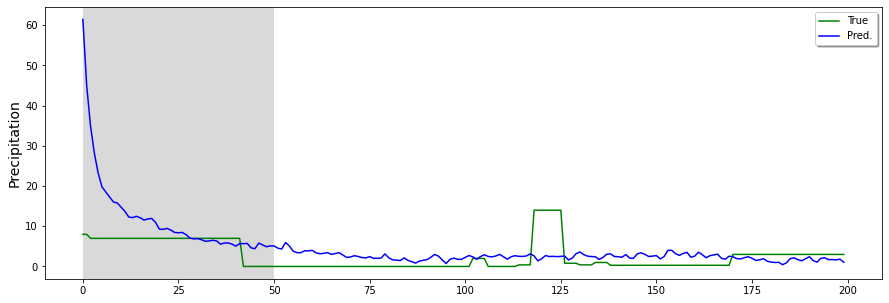

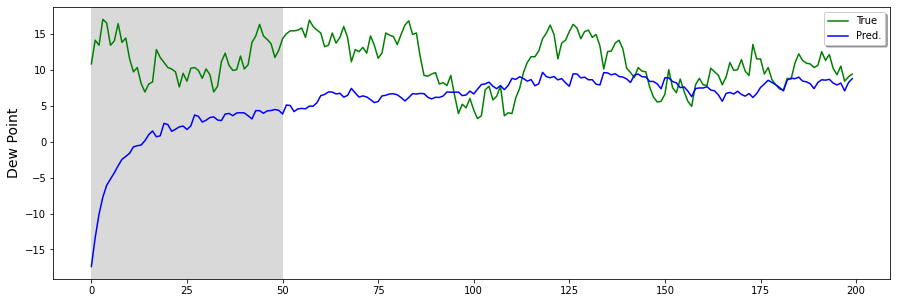

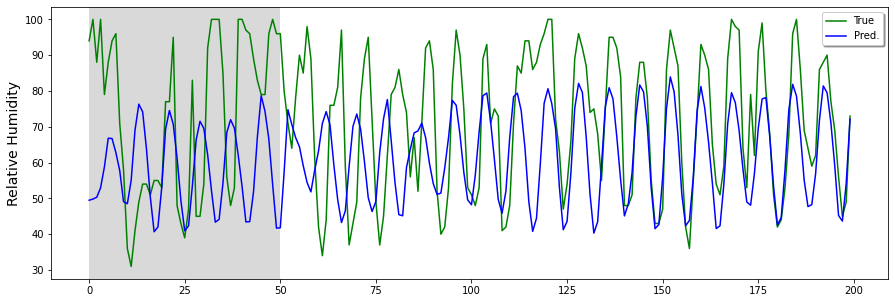

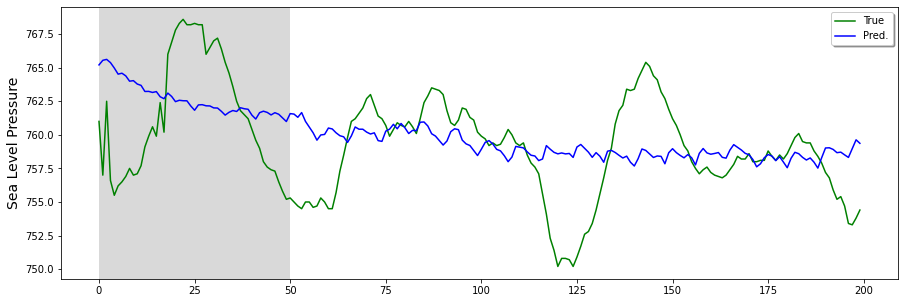

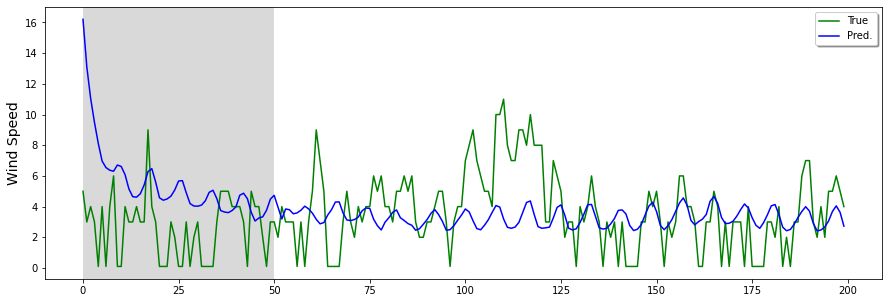

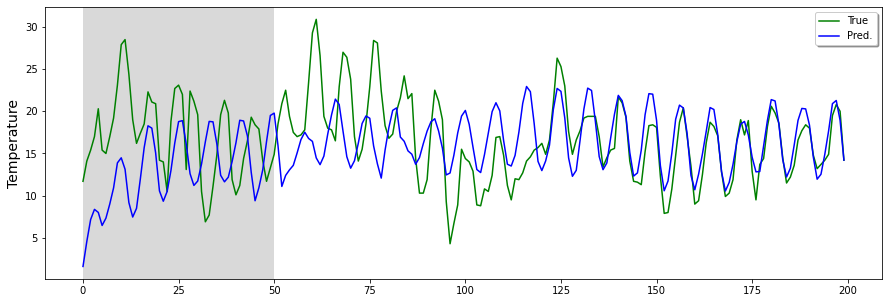

In [70]:
if is_example:
    plot_comparison(start_idx = 8 * 30 * 3, lenght = 200, train = False)

В качестве положительных моментов стоит отметить, что наша модель смогла выделить дневные циклы изменения силы ветра, влажности, точки росы, температуры и в какой-то степени осадков (учитывая ровный график истинных значений). Давление предсказано значительно хуже. Графики также показывают, что результаты предсказаний при такой модели отличаются от истинных значений. Такое положение вещей может быть связано с рядом проблем:  
* неправильный подбор параметров модели. Возможно, усложнение модели могло бы исправить ситуацию, но тогда вырастет время обучения. Например, можно изменить количество слоев и ядер, заменить GRU (LSTM) на двунаправленный LSTM, Conv слои, Encoder - Decoder архитектуру. 
* избыточность требований к RNN, которые не всегда способны работать с длинными последовательностями. На основании совокупности данных из 6 признаков, мы должны предсказать аналогичную совокупность в будущем. В данном примере мы должны предсказать значения параметров на 7 дней вперед (336 значений). Такое несоответствие ведет к тому, что модель не может уловить закономерности в данных.
* нехватка обучающих данных. Возможно, для такого длительного горизонта предсказаний - такой сложной задачи - необходимо брать больше исторических данных.
* применяемые метрики качества и оптимизатор плохо подходят для этой задачи.
   

<H3>Обучение моделей на одном столбце данных</H3>

Взяв во внимание вышеизложенное, обучим эту же сеть предсказывать по одной функции за раз. Применим тот же подход предсказания "многие-ко-многим", но будем предсказывать значение каждого параметра на один шаг вперед.

Удалим уже не нужные переменные.

In [71]:
if is_example:
    del model, dataset, generator, validation_data, callbacks, x_scaler, y_scaler

В начале создадим ряд вспомогательных функций и новых переменных.

In [72]:
if is_train:
    shift_days = 1
    shift_steps = shift_days * 1 #8
    train_split = 0.9
    single_x_scaler = MinMaxScaler(feature_range=(-1, 1))
    single_y_scaler = MinMaxScaler(feature_range=(-1, 1))
    save_dir = './'

In [9]:
# Функция создания тренировочного датафрейма
def create_training_set(data, column):
    data = data[[column]]
    return data

In [10]:
# Функция создания проверочного датасета
def create_targets_set(data, column):
    data = data[[column]].shift(-shift_steps)
    return data

In [11]:
# Функция построения графика одиночной модели для визулизации поэлементного предсказания
def single_plot_comparison_plus(start_idx, model_name, x, true, column, pred_scaler, lenght = 720, num = 55):
    # Конечный индекс последовательностей
    end_idx = start_idx + lenght
    # Выберите последовательности из заданного диапазона.
    x = x[start_idx:end_idx]
    true = true[start_idx:end_idx]
    lens = len(x)
    # Входные сигналы для модели.
    x_scaled = pred_scaler.fit_transform(x)
    x_scaled = np.expand_dims(x_scaled, axis = 0)
    # Создаем словарь для записи предсказаний 6 моделей
    
    preds = []
    print('Start inference:', column)

    pred = model.predict(x_scaled)
    pred_rescaled = pred_scaler.inverse_transform(pred[0])
    # print(len(pred_rescaled))
    # В список добавляем float значение, а не numpy array
    # if lens<lenght:
    #     preds.append(float(pred_rescaled[-1:]))
    # else:
    preds.append(float(pred_rescaled[lenght-1:]))
    # Итерационно предсказываем погоду, добавляя ранее предсказанные значения из списка во временной ряд
    for i in range(num):
        # Уменьшаем временной ряд на количество уже предсказанных значений
        pred_data = x[:lenght-1-i]
        
        # Создаем список для списков предсказанных элементов
        clean_preds = []
        # Заполняем список
        for element in preds:
            clean_preds.append([element])
        # Переворачиваем список, чтобы ранее предсказанные значения были в конце
        clean_preds.reverse()
        # Преобразуем список в numpay asarray
        clean_preds_asarray = np.asarray(clean_preds)
        # Вставляем полученные значения в начало pred_data
        pred_data_stack = np.vstack([clean_preds_asarray, pred_data])
        # Предсказываем очередное значение
        pred_scaled = pred_scaler.fit_transform(pred_data_stack)
        xy = np.expand_dims(pred_scaled, axis = 0)
        pred = model.predict(xy)
        pred_rescaled = pred_scaler.inverse_transform(pred[0])
        if col == 'Precipitation' or col == 'Wind Speed':
            # if lens<lenght:
            #     prc = float(pred_rescaled[-1:])
            # else:
            prc = float(pred_rescaled[lenght-1:])
            if prc<0:
                prc=0
            preds.append(prc)
        # else:
        #     if lens<lenght:
        #         preds.append(float(pred_rescaled[-1:]))
        else:
            preds.append(float(pred_rescaled[lenght-1:]))
    preds.reverse()
    # Расчитаем показатели регрессионных метрик для предсказаний модели
    mape = tf.keras.losses.MeanAbsolutePercentageError() # np.float32(true[-num-1:]), np.float32(preds))
    a = mape(np.float32(true[-num-1:]), np.float32(preds))
    mae = tf.keras.metrics.MeanAbsoluteError()
    b = mae(np.float32(true[-num-1:]), np.float32(preds))
    rmse = tf.keras.metrics.RootMeanSquaredError()
    c = rmse(np.float32(true[-num-1:]), np.float32(preds))
    print('MAPE:', float(a))
    print('MAE:', float(b))
    print('RMSE:', float(c))
    # Получение выходного сигнала, предсказанного моделью.
    signal_pred = preds

    # Получение истинного выходного сигнала из набора данных
    signal_true = true[-num-1:][:, 0]

    plt.figure(figsize = (15, 5))

    # Построение графика.
    plt.plot(signal_true, label = 'True', color = 'green')
    plt.plot(signal_pred, label = 'Pred.', color = 'blue')

    # Серый прямоугольник для периода прогрева.
    p = plt.axvspan(0, warmup_steps, facecolor = 'black', alpha = 0.15)

    # Нанесение меток.
    plt.ylabel(column, fontsize = 14)
    plt.legend(loc = 'best', shadow = True)
    plt.show()
    print('The end!')    
    return None

Start training: Precipitation
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 979s 1s/step - loss: 0.0055 - val_loss: 4.2174e-04

Epoch 00001: val_loss improved from inf to 0.00042, saving model to Precipitation.h5
Epoch 2/200
696/696 [==============================] - 956s 1s/step - loss: 7.6271e-04 - val_loss: 4.6603e-04

Epoch 00002: val_loss did not improve from 0.00

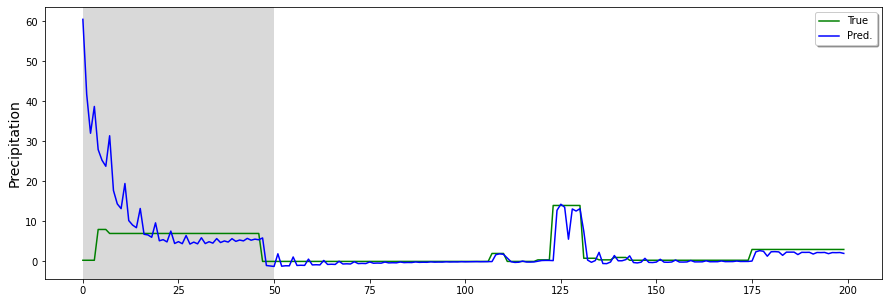

Start training: Temperature
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 937s 1s/step - loss: 0.0060 - val_loss: 0.0033

Epoch 00001: val_loss improved from inf to 0.00331, saving model to Temperature.h5
Epoch 2/200
696/696 [==============================] - 940s 1s/step - loss: 0.0027 - val_loss: 0.0033

Epoch 00002: val_loss improved from 0.00331 to 0.00328, saving 

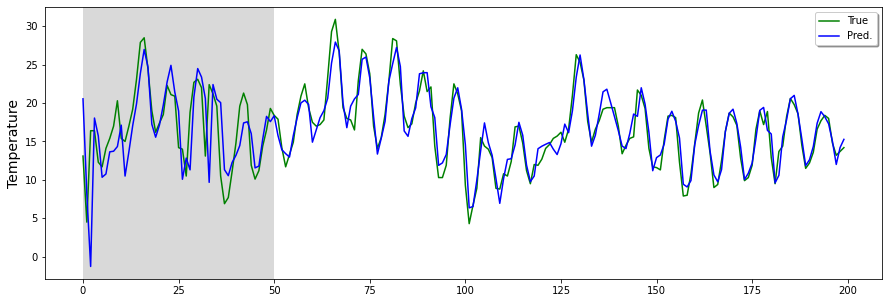

Start training: Dew Point
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 962s 1s/step - loss: 0.0034 - val_loss: 0.0014

Epoch 00001: val_loss improved from inf to 0.00138, saving model to Dew Point.h5
Epoch 2/200
696/696 [==============================] - 960s 1s/step - loss: 0.0017 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00138

Epoch 00002: Re

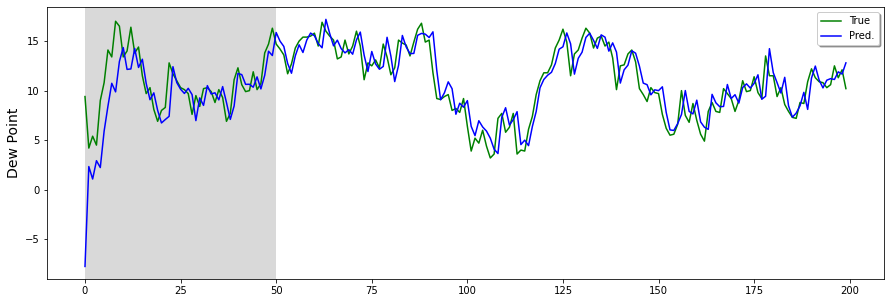

Start training: Relative Humidity
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 995s 1s/step - loss: 0.0379 - val_loss: 0.0351

Epoch 00001: val_loss improved from inf to 0.03515, saving model to Relative Humidity.h5
Epoch 2/200
696/696 [==============================] - 984s 1s/step - loss: 0.0272 - val_loss: 0.0342

Epoch 00002: val_loss improved from 0.03515 to 0.03

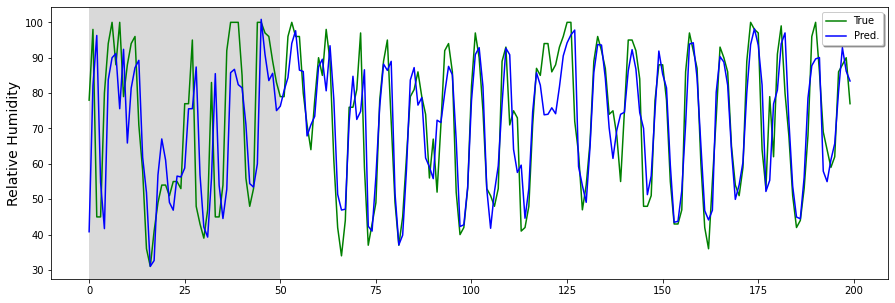

Start training: Sea Level Pressure
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 991s 1s/step - loss: 0.0015 - val_loss: 5.5662e-04

Epoch 00001: val_loss improved from inf to 0.00056, saving model to Sea Level Pressure.h5
Epoch 2/200
696/696 [==============================] - 982s 1s/step - loss: 7.4839e-04 - val_loss: 5.1264e-04

Epoch 00002: val_loss improved from 0

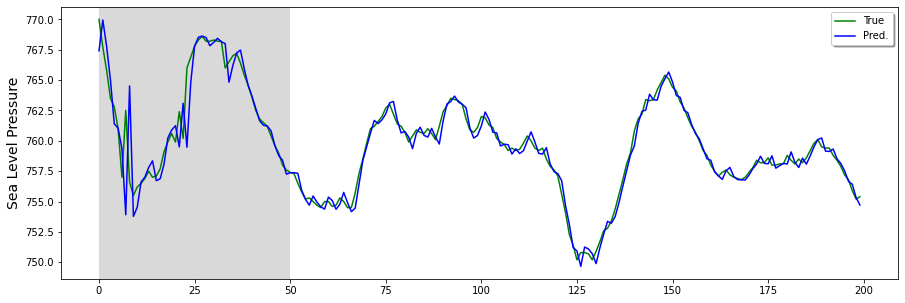

Start training: Wind Speed
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 969s 1s/step - loss: 0.0075 - val_loss: 0.0071

Epoch 00001: val_loss improved from inf to 0.00710, saving model to Wind Speed.h5
Epoch 2/200
696/696 [==============================] - 952s 1s/step - loss: 0.0041 - val_loss: 0.0069

Epoch 00002: val_loss improved from 0.00710 to 0.00690, saving mo

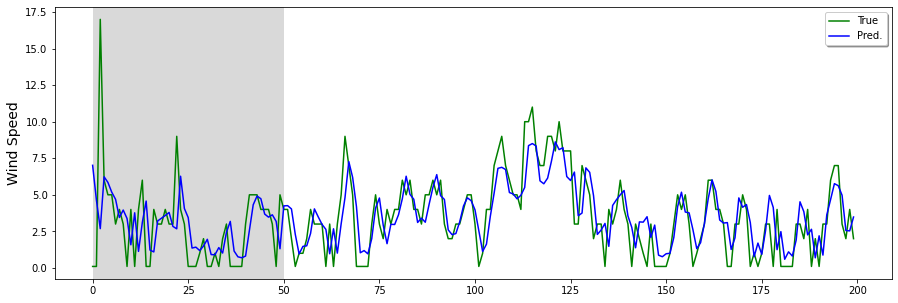

In [77]:
if is_train:
    # Загрузим файл данных и очистим его
    data_set = pd.read_csv('input/prophnet-cvs/guss_cleane_2013.csv', parse_dates = ['Date time'])
    data_set = clearing_dataset(data_set)
    data_set = adjustment(data_set)
    data_set = data_set.set_index('Date time')
    for col in columns:
        print('Start training:',col)
        # Создадим тренировочный DataFrame
        frame = create_training_set(data_set, col)

        # Создадим DataFrame со сдвинутыми во времени данными
        targets = create_targets_set(frame, col)
        
        # Отберем тренировочные и валидационные данные из DataFrames
        single_x_data = frame.values[0:-shift_steps]
        single_y_data = targets.values[:-shift_steps]
        # Определим общее количество значений, размер тренировочного и валидационного наборов
        single_num_data = len(single_x_data)
        single_num_train = int(train_split * single_num_data)
        single_num_test = single_num_data - single_num_train
        # Отделим тренировочные данные от валидационных
        single_x_train = single_x_data[0:single_num_train]
        single_x_test = single_x_data[single_num_train:]
        single_y_train = single_y_data[0:single_num_train]
        single_y_test = single_y_data[single_num_train:]
        # Проверим количество входных и выходных временных рядов
        single_num_x_signals = single_x_data.shape[1]
        single_num_y_signals = single_y_data.shape[1]
        
        # Масштабируем данные до нужного диапазона
        single_x_train_scaled = single_x_scaler.fit_transform(single_x_train)
        single_x_test_scaled = single_x_scaler.transform(single_x_test)
        
        single_y_train_scaled = single_y_scaler.fit_transform(single_y_train)
        single_y_test_scaled = single_y_scaler.transform(single_y_test)
        
        # Переопределим валидационные данные, добавив еще одну ось и создадим валидационный датасет 
        single_validation_data = (np.expand_dims(single_x_test_scaled, axis = 0),
                           np.expand_dims(single_y_test_scaled, axis = 0))
        #  Батч генератор
        single_generator = batch_generator(batch_size = batch_size, sequence_lenght = sequence_lenght, 
                                            num_tr = single_num_train,
                                            x_signals = single_num_x_signals,
                                            y_signals = single_num_y_signals,
                                            x_scaled = single_x_train_scaled, 
                                            y_scaled = single_y_train_scaled)
        # Модель
        model = Sequential([
            GRU(units = 64, # 128, 256, 512
                 return_sequences = True, input_shape = (None, single_num_x_signals,)),
            LSTM(64, return_sequences = True),
            TimeDistributed(Dense(single_num_y_signals, activation='linear'))  #activation = 'sigmoid')) #activation='softplus'))
#             Dense(single_num_y_signals, activation='sigmoid') #activation = 'sigmoid')) #activation='linear')) activation='softplus'))
        ])
        model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'], loss = loss_mse_warmup

        model.summary()
        # Обратные вызовы
        checkpoint = ModelCheckpoint(filepath = f'{col}.h5', monitor = 'val_loss', verbose = 1,
                                      save_weights_only = True, save_best_only = True)
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_lr = 1e-4, patience = 0, verbose = 1)

        model.fit(single_generator, 
                            epochs=200,
                            callbacks = [early_stopping, checkpoint, reduce_lr],
                            steps_per_epoch=single_x_train.shape[0]//batch_size,
                            validation_data=(single_validation_data))
        single_plot_comparison(start_idx = 8 * 30 * 3, model_name = model, 
                                x = single_x_test_scaled, true = single_y_test, column=col, lenght = 200, train = False)

Судя по графикам, модель отучилась значительно лучше, чем когда мы подавали в сеть сразу шесть функций за раз. Между двумя способами построения прогноза наблюдаются заметные различия. Подход с получением последовательности меньшего размера на графиках валидации выглядит более точным, чем поэлементный подход. 
Но! Если судить по показателям ошибки, то поэлементный прогноз немного превосходит подход с выбором уменьшенной последовательности.

Вполне возможно, что в процессе обучения происходила утечка информации из тестового набора в обучающий. Как минимум, специалисты советуют с осторожностью применять обратный вызов ранней остановки (early_stopping), чтобы такого не произошло.

Протестируем оба подхода на новых данных. На совершенно новом датасете.

### Тестирование на новых данных

Проверим работу модели с новыми тестовыми данными, с новым датасетом. Для начала реализуем процесс вывода с обученными ранее весами нашей модели. Потом запишем прогнозы в новый файл.

(обработаем csv файл с новыми тестовыми данными и запишем отсортированные данные в csv формат)

In [78]:
if is_train:
    del model, single_generator, single_validation_data, single_y_test_scaled, single_x_test_scaled, single_x_train_scaled, single_y_train_scaled, data_set

In [25]:
if is_inference:
    single_num_x_signals = 1
    single_num_y_signals = 1
    # Включение предсказания с уменьшением последовательности
    sequence = True

In [20]:
if is_inference:
#     test_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    pred_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    model = Sequential([
            GRU(units = 64, # 128, 256, 512,
                 return_sequences = True, input_shape = (None, single_num_x_signals,)),
            LSTM(64, return_sequences = True),
            TimeDistributed(Dense(single_num_y_signals, activation='linear')) #activation = 'sigmoid')) #activation='softplus'))
#             Dense(single_num_y_signals, activation='sigmoid') #activation = 'sigmoid')) #activation='linear'))
        ])
    model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'] # loss = loss_mse_warmup
    model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Функция построения графика для меньшей последовательности
def  draw_sequence_plot(y_true, y_pred, column):
    # Расчитаем показатели регрессионных метрик для предсказаний модели
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    a = mape(np.float32(y_true), np.float32(y_pred))
    mae = tf.keras.metrics.MeanAbsoluteError()
    b = mae(np.float32(y_true), np.float32(y_pred))
    rmse = tf.keras.metrics.RootMeanSquaredError()
    c = rmse(np.float32(y_true), np.float32(y_pred))
    print('MAPE:', float(a))
    print('MAE:', float(b))
    print('RMSE:', float(c))
    
    # Получение выходного сигнала, предсказанного моделью.
    signal_pred = y_pred

    # Получение истинного выходного сигнала из набора данных
    signal_true = y_true[:, 0]

    plt.figure(figsize = (15, 5))

    # Построение графика.
    plt.plot(signal_true, label = 'True', color = 'green')
    plt.plot(signal_pred, label = 'Pred.', color = 'blue')

    # Серый прямоугольник для периода прогрева.
    # p = plt.axvspan(0, warmup_steps, facecolor = 'black', alpha = 0.15)

    # Нанесение меток.
    plt.ylabel(column, fontsize = 14)
    plt.legend(loc = 'best', shadow = True)
    plt.show()
        
    return None

In [13]:
# Функция преобразования словаря в DataFrame pandas
def dict_to_csv(dictionary):   
    # Создаем датафрейм из значений времени
    # Прибавим к последнему времени 3 часа
    new_time = last_time+pd.to_timedelta('03:00:00')
    dti = pd.date_range(new_time, periods=56, freq="3H")
    dti.to_frame(index=False, name='Date time')
    dti = pd.DataFrame(dti, columns=['Date time'])
    
    # Перевернем датафрейм, чтобы последние часы были наверху
    dti = dti[::-1].reset_index(drop=True)
    
    # Получаем значения из словаря
    temperatura = dictionary['Temperature']
    precipitation = dictionary['Precipitation']
    point = dictionary['Dew Point']
    humidity = dictionary['Relative Humidity']
    pressure = dictionary['Sea Level Pressure']
    wind = dictionary['Wind Speed']
    
    # Запишем предсказанные значения в датафрейм
    dti['Temperature'] = temperatura
    dti['Precipitation'] = precipitation
    dti['Dew Point'] = point
    dti['Relative Humidity'] = humidity
    dti['Sea Level Pressure'] = pressure
    dti['Wind Speed'] = wind
    
    return dti

In [28]:
if is_inference:
    # Сделаем прогноз для каждой метеостанции
    data_test = pd.read_csv("input/prophnet-cvs/2016_cleane.csv", parse_dates = ['Date time'])
    last_time = data_test.iloc[0]['Date time']
    data_test = clearing_dataset(data_test)
    data_test = data_test.set_index('Date time')
    # data_test = adjustment_for_mape(data_test)
    # Создаем словари для записи предсказаний 6 моделей
    seq_dict = {}
    pred_dict = {}
    for col in columns:
        preds = []
        seqs = []
        print('Start inference:',col)
        print('----------------------------')
        pred_data = data_test.iloc[:720][[col]].values
        pred_scaled = pred_scaler.fit_transform(pred_data)
        x = np.expand_dims(pred_scaled, axis = 0)
        model.load_weights(f'{models_dir}/{col}.h5')
        pred = model.predict(x)
        pred_rescaled = pred_scaler.inverse_transform(pred[0])
        # В список добавляем float значение, а не numpy array
        preds.append(float(pred_rescaled[719:]))
        # Запишем в словарь предсказание меньшей последовательности
        for seq in list(pred_rescaled[:56]):
            sq = float(seq)
            if col == 'Precipitation' or col == 'Wind Speed':
                if sq<0.0:
                    sq=0.1
                seqs.append(sq)
            else:
                seqs.append(sq)
        seq_dict[f'{col}']=seqs
        # Итерационно предсказываем погоду, добавляя ранее предсказанные значения из списка во временной ряд
        for i in range(55):
            # Уменьшаем временной ряд на количество уже предсказанных значений
            pred_data = data_test.iloc[:719-i][[col]].values
            # Создаем список для списков предсказанных элементов
            clean_preds = []
            # Заполняем список
            for element in preds:
                clean_preds.append([element])
            # Переворачиваем список, чтобы ранее предсказанные значения были в конце
            clean_preds.reverse()
            # Преобразуем список в numpay asarray
            clean_preds_asarray = np.asarray(clean_preds)
            # Вставляем полученные значения в начало pred_data
            pred_data_stack = np.vstack([clean_preds_asarray, pred_data])
            # Предсказываем очередное значение
            pred_scaled = pred_scaler.fit_transform(pred_data_stack)
            xy = np.expand_dims(pred_scaled, axis = 0)
            pred = model.predict(xy)
            pred_rescaled = pred_scaler.inverse_transform(pred[0])
            if col == 'Precipitation' or col == 'Wind Speed':
                prc = float(pred_rescaled[719:])
                if prc<0:
                    prc=0
                preds.append(prc)
            else:
                preds.append(float(pred_rescaled[719:]))
        # Заполняем словарь
        pred_dict[f'{col}']=preds
    seq_df = dict_to_csv(seq_dict)
    pred_df = dict_to_csv(pred_dict)
    # Записываем предсказания в csv файл
    if sequence:
        seq_df.to_csv(f'{exit_dir}/seq_infer.csv', index=False)
        print(f'Предсказание с уменьшением последовательности завершено!')
        print('--------------------')
    else:
        pred_df.to_csv(f'{exit_dir}/elem_infer.csv', index=False)
        print(f'Поэлементное предсказание завершено!')
        print('--------------------')
    print('--------------------------------------------')

Start inference: Precipitation
----------------------------
Start inference: Temperature
----------------------------
Start inference: Dew Point
----------------------------
Start inference: Relative Humidity
----------------------------
Start inference: Sea Level Pressure
----------------------------
Start inference: Wind Speed
----------------------------
Предсказание с уменьшением последовательности завершено!
--------------------
--------------------------------------------


In [29]:
if is_inference:
    # print(dti.head())
    # Проверим DataFrame
    print(seq_df.head())

            Date time  Temperature  Precipitation  Dew Point  \
0 2022-03-28 15:00:00     7.106763       3.262973 -20.410913   
1 2022-03-28 12:00:00    -0.152181       5.305242  -8.756980   
2 2022-03-28 09:00:00    -6.797505       2.338566  -6.578923   
3 2022-03-28 06:00:00    -3.557421       0.100000  -6.629177   
4 2022-03-28 03:00:00     1.189905       0.100000  -7.187786   

   Relative Humidity  Sea Level Pressure  Wind Speed  
0          34.159607          714.775391         0.1  
1          49.753830          743.182922         0.1  
2          59.358253          763.487549         0.1  
3          64.124603          779.808716         0.1  
4          64.536713          781.251648         0.1  


### Расчет точности модели с использованием MAPE (средней абсолютной ошибки регрессии в процентах)

#### Основные регрессионные метрики.
**MAPE** является мерой точности прогноза метода прогнозирования в статистика, например в оценка тенденции, также используется как функция потерь для проблем регрессии в машинное обучение.

Данная оценка применяется для временных рядов, фактические значения которых значительно больше чем 1.

Если же фактические значения временного ряда близки к 0, то в знаменателе окажется очень маленькое число, что сделает значение MAPE близким к бесконечности – это не совсем корректно.

Для рядов, содержащих значения близкие к нулю, применяют другие оценщики.

**MSE** - самый простой и распространенный показатель для оценки регрессии. Чем выше его значение, тем хуже модель. Он никогда не бывает отрицательным, поскольку мы возводим в квадрат отдельные ошибки прогнозирования, прежде чем их суммировать, но для идеальной модели это будет ноль.

**MSE** в основном измеряет среднеквадратичную ошибку наших прогнозов. Для каждой точки вычисляется квадратная разница между прогнозами и целью, а затем усредняются эти значения.

НО, если мы сделаем один очень плохой прогноз, возведение в квадрат сделает ошибку еще хуже, и это может исказить метрику в сторону переоценки плохости модели. Это особенно проблематичное поведение, если у нас есть зашумленные данные (то есть данные, которые по какой-либо причине не совсем надежны) - даже в «идеальной» модели может быть высокий **MSE** в этой ситуации, поэтому становится трудно судить, насколько хорошо модель выполняет.

**RMSE** - это просто квадратный корень из MSE. Квадратный корень введен, чтобы масштаб ошибок был таким же, как масштаб целей. Это означает, что путешествие по градиенту MSE эквивалентно путешествию по градиенту RMSE, но с другой скоростью потока. Так же существует проблема RMSE, если в любом из входных списков есть нули или бесконечность, то выходное значение RSME не будет иметь смысла. В общем, предпочтительным является игнорирование любого компонента с отсутствующим значением, но это смещает RMSE к нулю, заставляя нас думать, что производительность улучшилась, хотя на самом деле это не так. Добавление случайного шума по наилучшему предположению может быть предпочтительным, если имеется много пропущенных значений.

**MAE** - средняя абсолютная ошибка. Средняя абсолютная ошибка относится к среднему значению расстояния между предсказанным значением модели и истинным значением y образца. С помощью MAE мы можем получить представление о том, насколько неправильными были прогнозы. MAE не указывает направление модели, то есть не указывает на недостаточную производительность модели.


### Связь точности и ошибки прогнозирования

Точность прогнозирования есть понятие прямо противоположное ошибке прогнозирования. Если ошибка прогнозирования велика, то точность мала и наоборот, если ошибка прогнозирования мала, то точность велика. По сути дела оценка ошибки прогноза MAPE есть обратная величина для точности прогнозирования.

**Точность прогноза в % = 100% – MAPE**

Величину точности оценивать не принято, говоря о прогнозировании всегда оценивают, то есть определяют значение, именно ошибки прогноза, то есть величину MAPE и/или MAE. Однако нужно понимать, что если MAPE = 5%, то точность прогнозирования = 95%. Говоря о высокой точности, всегда говорится о низкой ошибки прогноза. 

В наших наборах данных много нулей, особенно в столбце с названием "Осадки". Есть три стратегии, чтобы иметь дело с нулями или отсутствующими значениями в любом списке: игнорировать этот компонент, обнулять его, или добавлять наилучшее предположение, или равномерный случайный шум для всех временных шагов. Каждый вариант имеет свои плюсы и минусы в зависимости от того, что означают ваши данные. В качестве альтернативы каждое фактическое значение ряда в исходной формуле может быть заменено средним значением всех фактических значений этого ряда. Мы можем попробовать заменить нули другим значением и посмотреть что получится.

In [ ]:
# Удалим уже не нужные переменные
if is_inference:
    del model, pred_dict, pred_scaler, preds, clean_preds, dti, pred_data, data_test, clean_preds_asarray, pred_data_stack

In [31]:
if is_mape:
    single_num_x_signals = 1
    single_num_y_signals = 1
    test_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    pred_scaler = MinMaxScaler(feature_range=(0.1, 0.9))

In [32]:
if is_mape:
    def adjustment_for_mape(data):
        # Заменим нули близким значением на выбор
        data = data.replace({'Precipitation': {0.0 : 0.1}, 'Temperature': {0.0 : 0.1}, 'Dew Point': {0.0 : 1.0}, 'Wind Speed': {0.0 : 0.1}, 
                               'Relative Humidity': {0.0 : 0.1}, 'Sea Level Pressure': {0.0 : 0.1}})
        return data

In [33]:
if is_mape:
    model = Sequential([
            GRU(units = 64, # 128, 256, 512
                 return_sequences = True, input_shape = (None, single_num_x_signals,)),
            LSTM(64, return_sequences = True),
            TimeDistributed(Dense(single_num_y_signals, activation='linear')) #activation = 'sigmoid')) #activation='softplus'))
#             Dense(single_num_y_signals, activation='sigmoid') #activation = 'sigmoid')) #activation='linear')) #activation='softplus')
        ])
    model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'] # loss = loss_mse_warmup
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [34]:
models_dir = '.'

Для вывода и визуализации предсказаний нейронной сети применим два разных способа и оценим какой из них лучше. В первом случае мы будем получать из последовательности предсказания для меньшей последовательности, во втором мы будем получать из последовательности предсказание последнего элемента, а затем встраивать его в последовательность для последующего предсказания, пока не получим последовательность нужной длины.

Start inference: Precipitation
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 193.19456481933594
MAE: 0.19319455325603485
RMSE: 0.8833407759666443


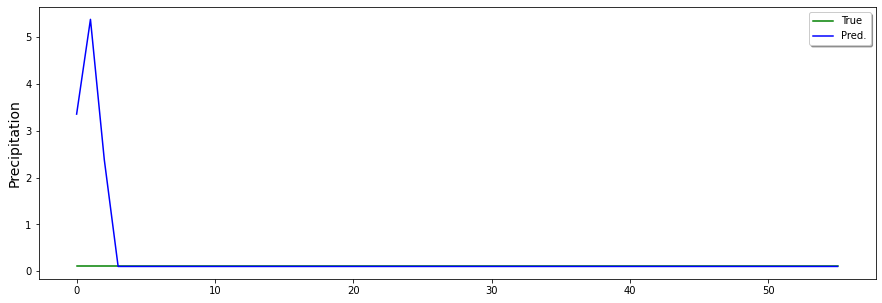

График для поэлементной последовательности:
-------------------------------------------
MAPE: 1073.8502197265625
MAE: 1.0738502740859985
RMSE: 1.641930103302002


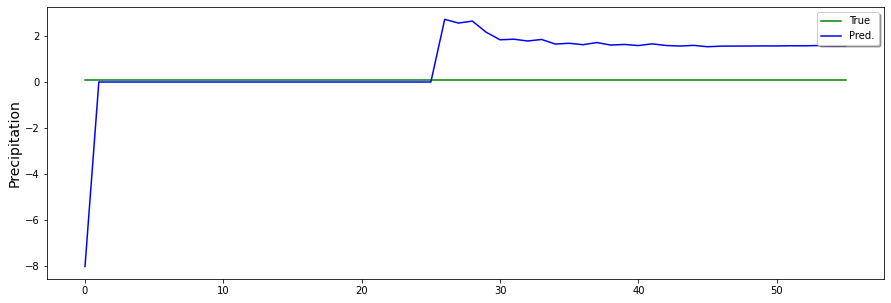

Start inference: Temperature
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 758.1063232421875
MAE: 7.391926288604736
RMSE: 8.540990829467773


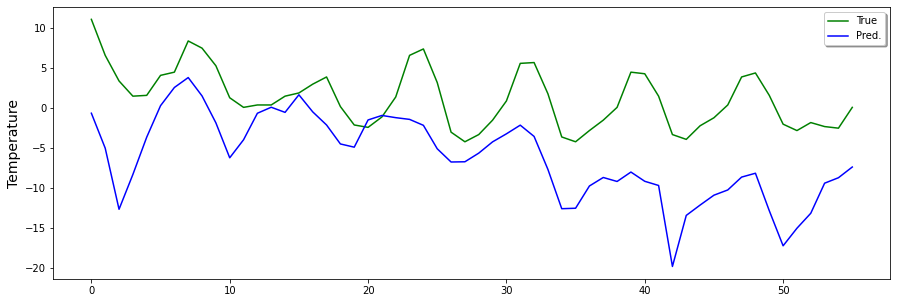

График для поэлементной последовательности:
-------------------------------------------
MAPE: 1244.9769287109375
MAE: 12.145766258239746
RMSE: 13.007416725158691


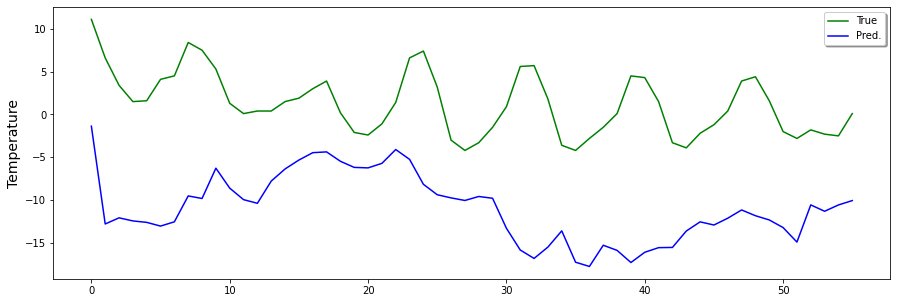

Start inference: Dew Point
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 552.6480712890625
MAE: 6.1253509521484375
RMSE: 6.844274997711182


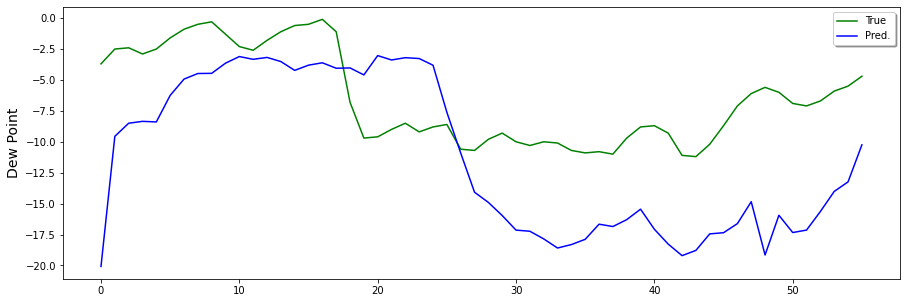

График для поэлементной последовательности:
-------------------------------------------
MAPE: 640.0719604492188
MAE: 7.334705829620361
RMSE: 8.359980583190918


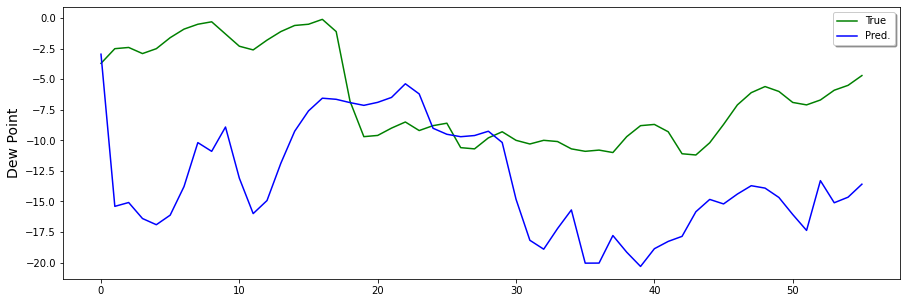

Start inference: Relative Humidity
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 35.05570602416992
MAE: 12.950698852539062
RMSE: 17.077301025390625


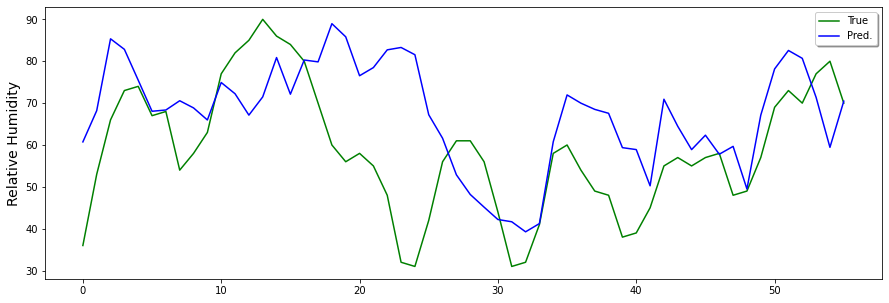

График для поэлементной последовательности:
-------------------------------------------
MAPE: 53.67495346069336
MAE: 25.561975479125977
RMSE: 29.39410400390625


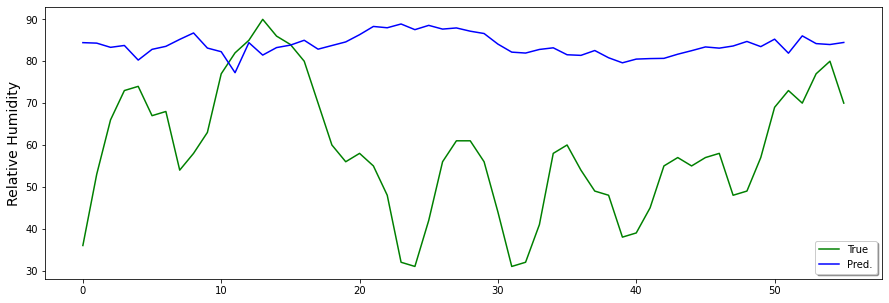

Start inference: Sea Level Pressure
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 1.264565348625183
MAE: 9.266631126403809
RMSE: 12.944759368896484


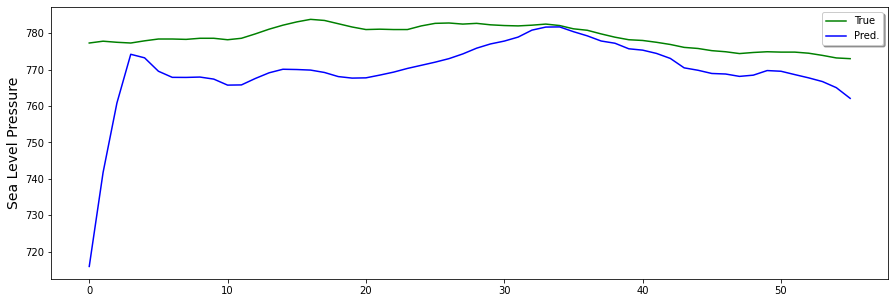

График для поэлементной последовательности:
-------------------------------------------
MAPE: 3.5784242153167725
MAE: 27.88892936706543
RMSE: 30.39827537536621


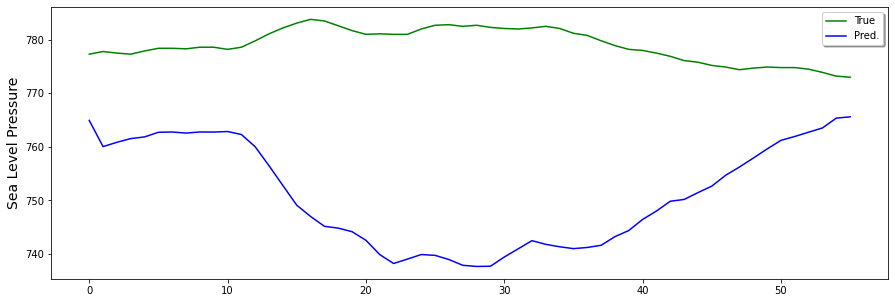

Start inference: Wind Speed
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 88.68228912353516
MAE: 2.2057480812072754
RMSE: 2.386662244796753


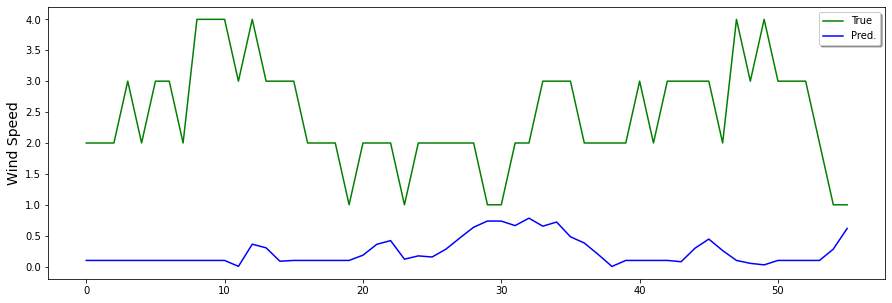

График для поэлементной последовательности:
-------------------------------------------
MAPE: 58.20216751098633
MAE: 1.3122398853302002
RMSE: 1.6126998662948608


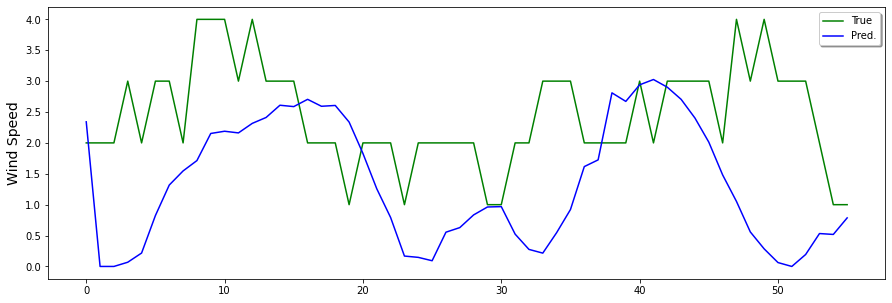

The end!


In [36]:
if is_mape:
    # Откроем один файл с данными и создадим проверочный набор
    data_test = pd.read_csv("input/prophnet-cvs/2016_cleane.csv", parse_dates = ['Date time'])
    last_time = data_test.iloc[0]['Date time']
    data_test = clearing_dataset(data_test)
    data_test = data_test.set_index('Date time')
    data_test = adjustment_for_mape(data_test)
    # Создаем словари для записи предсказаний 6 моделей
    seq_dict = {}
    pred_dict = {}
    for col in columns:
        preds = []
        seqs = []
        print('Start inference:',col)
        print('----------------------------')
        true_data = data_test.iloc[:56][[col]].values
        pred_data = data_test.iloc[56:776][[col]].values
        pred_scaled = pred_scaler.fit_transform(pred_data)
        x = np.expand_dims(pred_scaled, axis = 0)
        model.load_weights(f'{models_dir}/{col}.h5')
        pred = model.predict(x)
        pred_rescaled = pred_scaler.inverse_transform(pred[0])
        # В список добавляем float значение, а не numpy array
        preds.append(float(pred_rescaled[719:]))
        # Запишем в словарь предсказание меньшей последовательности
        for seq in list(pred_rescaled[:56]):
            sq = float(seq)
            if col == 'Precipitation' or col == 'Wind Speed':
                if sq<0.0:
                    sq=0.1
                seqs.append(sq)
            else:
                seqs.append(sq)
        # Визуализируем график уменьшенной последовательности
        print('График для уменьшенной последовательности:')
        print('------------------------------------------')
        draw_sequence_plot(true_data, seqs, column=col)
        seq_dict[f'{col}']=seqs
        # Итерационно предсказываем погоду, добавляя ранее предсказанные значения из списка во временной ряд
        for i in range(55):
            # Уменьшаем временной ряд на количество уже предсказанных значений
            pred_data = data_test.iloc[:719-i][[col]].values
            # Создаем список для списков предсказанных элементов
            clean_preds = []
            # Заполняем список
            for element in preds:
                clean_preds.append([element])
            # Переворачиваем список, чтобы ранее предсказанные значения были в конце
            clean_preds.reverse()
            # Преобразуем список в numpay asarray
            clean_preds_asarray = np.asarray(clean_preds)
            # Вставляем полученные значения в начало pred_data
            pred_data_stack = np.vstack([clean_preds_asarray, pred_data])
            # Предсказываем очередное значение
            pred_scaled = pred_scaler.fit_transform(pred_data_stack)
            xy = np.expand_dims(pred_scaled, axis = 0)
            pred = model.predict(xy)
            pred_rescaled = pred_scaler.inverse_transform(pred[0])
            if col == 'Precipitation' or col == 'Wind Speed':
                prc = float(pred_rescaled[719:])
                if prc<0:
                    prc=0
                preds.append(prc)
            else:
                preds.append(float(pred_rescaled[719:]))
        # Заполняем словарь
        print('График для поэлементной последовательности:')
        print('-------------------------------------------')
        draw_sequence_plot(true_data, preds, column=col)
        pred_dict[f'{col}']=preds
    seq_df = dict_to_csv(seq_dict)
    pred_df = dict_to_csv(pred_dict)
    # Записываем предсказания в csv файл
#     pred_df.to_csv(f'{save_dir}/pred_mape.csv', index=False)
#     pred_df.to_csv(f'./pred_mape.csv', index=False)
#     seq_df.to_csv(f'{save_dir}/seq_mape.csv', index=False)
    print('The end!')

На новых данных соотношение между подходами остается тем же, по крайней мере в этой задаче и с этими данными. Поэлементный прогноз уступает в качестве.

Тренд был определен только для силы ветра и осадков. Говорить о точности модели можно только в случае осадков, да и то с оговоркой о том, что в течении года наблюдается значительное количество дней когда осадки не выпадали.

Возможно, что можно улучшить качество предсказаний изменив архитектуру модели, усложнить ее, применить другие методы вывода, с увеличением длины прогноза точность снижается. В нашей задаче нужно предсказать ряд длиной в 56 временных шагов, что само по себе является сложной задачей.

<h3>Точность прогноза</h3>

Проверим насколько точны предсказания нейронной сети еще раз рассчитав показатели ошибки. Выберем лучший подход по итогам проверки на этой задаче, а именно прогноз с использованием уменьшенной последовательности.

In [119]:
if is_mape:
    # Функция расчета симметричной MAPE
    def smape(a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [120]:
if is_mape:
    for column in columns:
        test_data = data_test.iloc[:56][[column]].values
        pred_data = dti[[column]].values
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        mape_column = mape(test_data, pred_data)
        rmse= tf.keras.metrics.RootMeanSquaredError()
        rmse_column = rmse(test_data, pred_data)
        smape_column = smape(test_data, pred_data)
        print('MAPE:', column, ':', float(mape_column), 'Точность:', 100-float(mape_column))
        print('RMSE:', column, ':', float(rmse_column), 'Точность:', 1.96*float(rmse_column))
        print('SMAPE:', column, ':', float(smape_column), 'Точность:', 100-float(smape_column))
        print('----------------------------------------------------------------')

MAPE: Precipitation : 1073.850341796875 Точность: -973.850341796875
RMSE: Precipitation : 1.641930103302002 Точность: 3.218183002471924
SMAPE: Precipitation : 188.15022283165473 Точность: -88.15022283165473
----------------------------------------------------------------
MAPE: Temperature : 551.7201538085938 Точность: -451.72015380859375
RMSE: Temperature : 7.940988063812256 Точность: 15.564336605072022
SMAPE: Temperature : 153.83078623404305 Точность: -53.830786234043046
----------------------------------------------------------------
MAPE: Dew Point : 407.6335754394531 Точность: -307.6335754394531
RMSE: Dew Point : 5.150013446807861 Точность: 10.094026355743408
SMAPE: Dew Point : 76.65798690490385 Точность: 23.34201309509615
----------------------------------------------------------------
MAPE: Relative Humidity : 29.454845428466797 Точность: 70.5451545715332
RMSE: Relative Humidity : 22.7408447265625 Точность: 44.572055664062496
SMAPE: Relative Humidity : 35.00588360609274 Точность:

In [121]:
if is_mape:
    test_data = data_test.iloc[:56][columns].values
    pred_data = dti[columns].values
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    mape_column = mape(test_data, pred_data)
    rmse= tf.keras.metrics.RootMeanSquaredError()
    rmse_column = rmse(test_data, pred_data)
    smape_column = smape(test_data, pred_data)
    print('MAPE:', float(mape_column), 'Точность:', 100-float(mape_column))
    print('RMSE:', float(rmse_column), 'Точность:', 1.96*float(rmse_column))
    print('SMAPE:', float(smape_column), 'Точность:', 100-float(smape_column))
    print('----------------------------------------------------------------')

MAPE: 364.81646728515625 Точность: -264.81646728515625
RMSE: 163.687744140625 Точность: 320.827978515625
SMAPE: 646.5384940607623 Точность: -546.5384940607623
----------------------------------------------------------------


Точность прогноза температуры и точки росы имеет отрицательное значение, как и общая точность прогноза по всему набору данных. Это связано с тем что MAPE имеет ряд особенностей, благодаря которым эту метрику не используют для оценки моделей предсказания погоды. 
* для этой метрики важно чтобы шкала измерения имела значимый ноль (в этом случае фиксированый ноль, как начало шкалы), а температура, точка росы и им подобные системы измерения являются шкалами интервалов и включают в себя произвольный ноль.
* МАРЕ во время работы налагает повышенные штрафы на отрицательные ошибки (когда их значение ниже нуля). Таких ошибок при определении МАРЕ отрицательных температур более, чем достаточно.
* У моделей предсказания временных рядов вообще не принято рассчитывать точность, потому что корректно определить этот показатель получается крайне редко, только если ряды отвечают требованиям.
* Иногда допускается измерение точности на основе показателей RMSE, формула для этого выглядит так: 1.96хRMSE. Ее применяют согласно National Digital Elevation Guidelines и FEMA guidelines для определения Фундаментальной вертикальной точности рельефа, но не для предсказания погоды.

Согласно установленным стандартам, хороший прогноз, например температуры, считается таковым, если отличается от истинного значения максимум на 3.5 градуса. Таких прогнозов добиваются, но не всегда, используя мощные суперкомпьютеры, два из которых входят в топ самых мощных в мире. Используются специальные числовые системы прогнозирования погоды с массой формул и параметров, на расчет которых у человека, по словам специалистов, уходит больше времени, чем остается до дня на который расчитывается прогноз.

Есть и менее затратные системы программ для выработки прогноза погоды, такие как WRF-ARM, которые менее затратны и сложны, а потому более популярны. Но они также требуют значительных вычислительных ресурсов и знаний. Эти системы способны давать прогноз на длительный срок, для произвольной территории. Попробуем реализовать что-то подобное.

### Интерполяция

С математической точки зрения **интерполяция** указывает на процесс получения значения конкретных неизвестных точек данных, это способ нахождения промежуточных значений величины по имеющемуся дискретному набору известных значений. **Интерполяция** представляет собой мощный инструмент для анализа данных, для изготовления прогнозов и для многих других различных приложений.

Поскольку мы имеем дело с двумерными точками данных, чтобы построить их, нам нужно создать сетку точек, а затем назначать определенное значение для всех точек на сетке; Это будут нашими начальными, известными точками данных, от которых мы интерполизируем значения других точек данных.

In [44]:
# Удалим уже не нужные переменные
if is_mape:
    del model, pred_dict, pred_scaler, preds, clean_preds, dti, pred_data, data_test, clean_preds_asarray, pred_data_stack

In [27]:
if is_interpolation:
    inter_dir = 'input/3-csv-lstm'
    exit_dir = '.'
    models_dir = 'input/gru-best-w/gru_best_w'

In [34]:
if is_interpolation:
    single_num_x_signals = 1
    single_num_y_signals = 1
    test_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    pred_scaler = MinMaxScaler(feature_range=(0.1, 0.9))

In [35]:
if is_interpolation:
    model = Sequential([
            GRU(units = 64, # 128, 256, 512
                 return_sequences = True, input_shape = (None, single_num_x_signals,)),
            LSTM(64, return_sequences = True),
            TimeDistributed(Dense(single_num_y_signals, activation='linear')) #activation = 'sigmoid')) #activation='softplus'))
#             Dense(single_num_y_signals, activation='sigmoid') #activation = 'sigmoid')) #activation='linear')) #activation='softplus')
        ])
    model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'] # loss = loss_mse_warmup
    model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1)           65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [38]:
if is_interpolation:
    # Сделаем прогноз для каждой метеостанции
    for csv in os.listdir(inter_dir):
        if csv.endswith('.csv'):
            data_test = pd.read_csv(f"{inter_dir}/{csv}", parse_dates = ['Date time'])
            last_time = data_test.iloc[0]['Date time']
            data_test = clearing_dataset(data_test)
            data_test = data_test.set_index('Date time')
            # Создаем словарь для записи предсказаний 6 моделей
            pred_dict = {}
            for col in columns:
                preds = []
                print('Start inference:',col)
                pred_data = data_test.iloc[:720][[col]].values
                pred_scaled = pred_scaler.fit_transform(pred_data)
                x = np.expand_dims(pred_scaled, axis = 0)
                model.load_weights(f'{models_dir}/{col}.h5')
                pred = model.predict(x)
                pred_rescaled = pred_scaler.inverse_transform(pred[0])
                # В список добавляем float значение, а не numpy array
                preds.append(float(pred_rescaled[719:]))
                # Итерационно предсказываем погоду, добавляя ранее предсказанные значения из списка во временной ряд
                for i in range(55):
                    # Уменьшаем временной ряд на количество уже предсказанных значений
                    pred_data = data_test.iloc[:719-i][[col]].values
                    # Создаем список для списков предсказанных элементов
                    clean_preds = []
                    # Заполняем список
                    for element in preds:
                        clean_preds.append([element])
                    # Переворачиваем список, чтобы ранее предсказанные значения были в конце
                    clean_preds.reverse()
                    # Преобразуем список в numpay asarray
                    clean_preds_asarray = np.asarray(clean_preds)
                    # Вставляем полученные значения в начало pred_data
                    pred_data_stack = np.vstack([clean_preds_asarray, pred_data])
                    # Предсказываем очередное значение
                    pred_scaled = pred_scaler.fit_transform(pred_data_stack)
                    xy = np.expand_dims(pred_scaled, axis = 0)
                    pred = model.predict(xy)
                    pred_rescaled = pred_scaler.inverse_transform(pred[0])
                    if col == 'Precipitation':
                        prc = float(pred_rescaled[719:])
                        if prc<0:
                            prc=0
                        preds.append(prc)
                    else:
                        preds.append(float(pred_rescaled[719:]))
                # Заполняем словарь
                preds.reverse()
                pred_dict[f'{col}']=preds
            # Записываем словарь в csv
            # Создаем датафрейм из значений времени
            # Прибавим к последнему времени 3 часа (создадим начальную точку)
            new_time = last_time+pd.to_timedelta('03:00:00')
            dti = pd.date_range(new_time, periods=56, freq="3H")
            dti.to_frame(index=False, name='Date time')
            dti = pd.DataFrame(dti, columns=['Date time'])
            # Перевернем датафрейм, чтобы последние часы были наверху
            dti = dti[::-1].reset_index(drop=True)
            # Получаем значения из словаря
            temperatura = pred_dict['Temperature']
            precipitation = pred_dict['Precipitation']
            point = pred_dict['Dew Point']
            humidity = pred_dict['Relative Humidity']
            pressure = pred_dict['Sea Level Pressure']
            wind = pred_dict['Wind Speed']
            # Запишем предсказанные значения в датафрейм
            dti['Temperature'] = temperatura
            dti['Precipitation'] = precipitation
            dti['Dew Point'] = point
            dti['Relative Humidity'] = humidity
            dti['Sea Level Pressure'] = pressure
            dti['Wind Speed'] = wind
            # Записываем предсказания в csv файл
            #     dti.to_csv(f'{save_dir}/pred_clean.csv', index=False)
            dti.to_csv(f'{exit_dir}/pred_{csv}', index=False)
            print(f'{csv} - the end!')
            print('--------------------')

Start inference: Precipitation
Start inference: Temperature
Start inference: Dew Point
Start inference: Relative Humidity
Start inference: Sea Level Pressure
Start inference: Wind Speed
2009_novosib_cleane.csv - the end!
--------------------
Start inference: Precipitation
Start inference: Temperature
Start inference: Dew Point
Start inference: Relative Humidity
Start inference: Sea Level Pressure
Start inference: Wind Speed
2016_cleane.csv - the end!
--------------------
Start inference: Precipitation
Start inference: Temperature
Start inference: Dew Point
Start inference: Relative Humidity
Start inference: Sea Level Pressure
Start inference: Wind Speed
guss_cleane_2013.csv - the end!
--------------------
Start inference: Precipitation
Start inference: Temperature
Start inference: Dew Point
Start inference: Relative Humidity
Start inference: Sea Level Pressure
Start inference: Wind Speed
ovosib_cleane.csv - the end!
--------------------


#### Для четырех csv файлов

Все самые известные и популярные методы интерполяции, такие как IDW, RBF, Interp2d, griddata, требуют как минимум 4 значения на каждой оси. По этому нам потребуется 4 файла с данными, которые мы скачиваем с rp5.

In [41]:
if is_interpolation:
    # Словарь csv - координаты
    coords = {'./pred_2016_cleane.csv': [59.641658, 65.708358],
             './pred_guss_cleane_2013.csv':[59.9491658, 65.968358],
              './pred_2009_novosib_cleane.csv':[59.8491658, 65.998358],
              './ovosib_cleane.csv': [59.4491658, 65.698358],
              'target':[59.7491658, 65.908358]}
    file_1 = './pred_2016_cleane.csv'
    file_2 = './pred_guss_cleane_2013.csv'
    file_3 = './pred_2009_novosib_cleane.csv'
    file_4 = './ovosib_cleane.csv'

In [42]:
if is_interpolation:
    # Создадим списки для хранения полученных данных
    temperatura = []
    precipitation = []
    point = []
    humidity = []
    pressure = []
    wind = []
    #
    num_pts = 10
    # Прочитаем файлы
    data_1 = pd.read_csv(file_1)
    data_2 = pd.read_csv(file_2)
    data_3 = pd.read_csv(file_3)
    data_4 = pd.read_csv(file_4)
    # Столбец с датами
    dates = data_1['Date time'].values
    # Пройдемся в цикле по файлам
    for col in columns:
        # У нас 56 шагов
        for i in range(56):
            # Назначим переменные для расчетов
            x_1 = coords[file_1][0]
            y_1 = coords[file_1][1]
            x_2 = coords[file_2][0]
            y_2 = coords[file_2][1]
            x_3 = coords[file_3][0]
            y_3 = coords[file_3][1]
            x_4 = coords[file_4][0]
            y_4 = coords[file_4][1]
            z_1 = data_1.iloc[i][col]
            z_2 = data_2.iloc[i][col]
            z_3 = data_3.iloc[i][col]
            z_4 = data_4.iloc[i][col]
            # Чтобы не было ошибки деления на ноль
            if z_1==0.0 and z_2==0.0 and z_3==0.0 and z_4==0.0:
                z_new=0.0
            else:
                # Проведем интерполяцию
                df = pd.DataFrame({'x':[x_1, x_2, x_3, x_4], 'y':[y_1, y_2, y_3, y_4], 'z':[z_1, z_2, z_3, z_4]})
                df['z'] = df['z'].fillna(0.0)
                # Создадим сетку координат
                x_grid = np.linspace(min(df['x']), max(df['x']), num_pts)
                y_grid = np.linspace(min(df['y']), max(df['y']), num_pts)
                # Создадим функцию координат и значений
                f = interp2d(df['x'], df['y'], df['z'], kind='linear')
                # Передадим координаты метеостанции и получим значение предсказания
                x_t = coords['target'][0]
                y_t = coords['target'][1]
                x_prime, y_prime = (x_t, y_t)
                z_new = f(x_prime, y_prime)
                # Вставим результат в список
            if col == 'Temperature':
                temperatura.append(z_new[0])
            elif col == 'Precipitation':
                precipitation.append(z_new[0])
            elif col == 'Dew Point':
                point.append(z_new[0])
            elif col == 'Relative Humidity':
                humidity.append(z_new[0])
            elif col == 'Sea Level Pressure':
                pressure.append(z_new[0])
            elif col == 'Wind Speed':
                wind.append(z_new[0])
    # Запишем прогноз в файл
    inter_csv = pd.DataFrame({'Date time': dates, 'Temperature':temperatura, 'Dew Point':point, 'Relative Humidity':humidity, 
                              'Sea Level Pressure':pressure, 'Wind Speed':wind, 'Precipitation':precipitation})
    inter_csv.to_csv('cells.csv', index=False)
    print(inter_csv.head())
    print(f'The end!')
    print('--------------------')

             Date time  Temperature  Dew Point  Relative Humidity  \
0  2022-03-28 15:00:00   -20.170540   4.404579          65.944708   
1  2022-03-28 12:00:00   -19.813068   3.839777          64.109823   
2  2022-03-28 09:00:00   -17.268869   5.477829          71.140926   
3  2022-03-28 06:00:00   -18.914480   7.224940          75.560265   
4  2022-03-28 03:00:00   -21.984371   4.875732          75.682862   

   Sea Level Pressure  Wind Speed  Precipitation  
0          983.025758   -1.272233      -0.105253  
1          982.906183   -1.587511      -0.308754  
2          981.327034   -1.523631      -0.246399  
3          980.120706   -2.046650      -0.323112  
4          978.105970   -1.938962      -0.301468  
The end!
--------------------


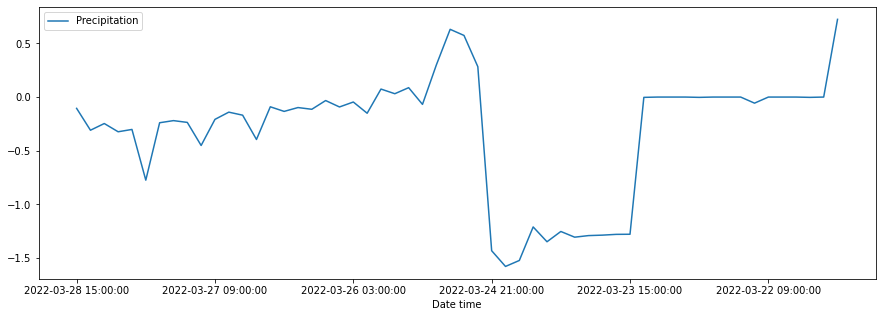

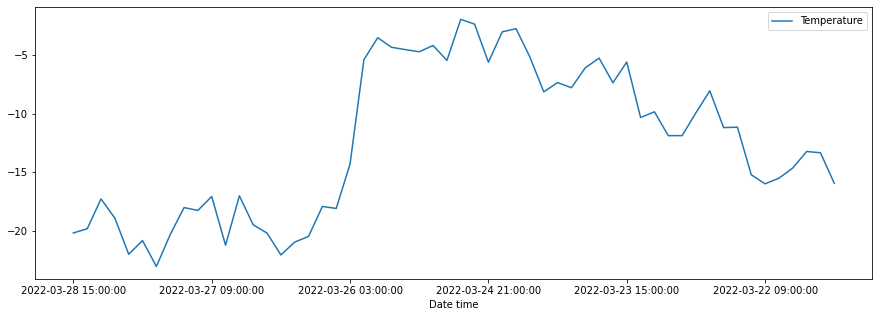

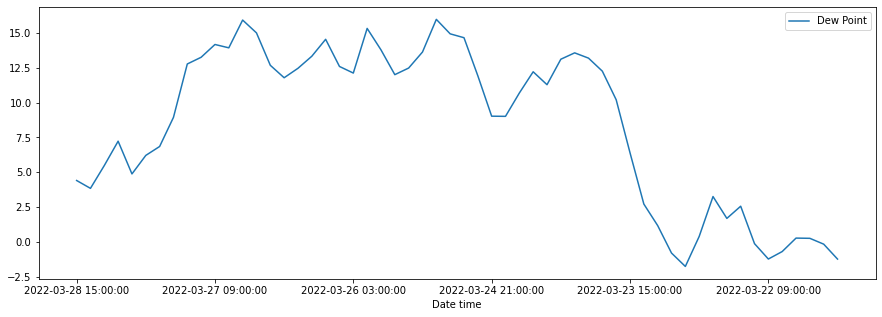

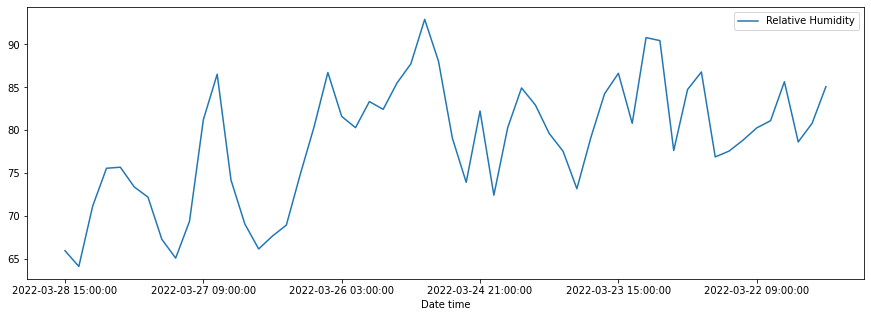

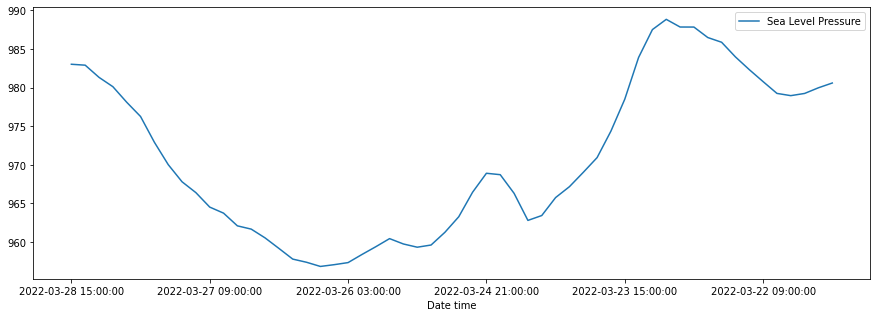

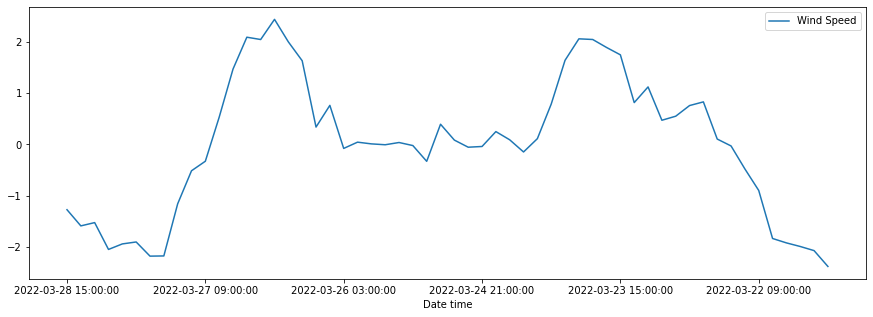

In [43]:
if is_interpolation:
    # Отображение всех функций на временной шкале
    for feature in columns:
        inter_csv.plot(x="Date time", y=[feature], figsize=(15,5))
        plt.show()

Интерполяция проведена. Прогноз погоды в точке, в которой не проводились сборы данных, получен.

### Эксперимент

<p>Проведем эксперимент по прогнозированию погоды на неделю вперед в некоторой точке на карте. Для эксперимента нам потребуется скачать с rp5 минимум 10 файлов с историческими погодными данными для каждого региона (региональных метеостанций может быть еще меньше). Регионов может быть любое количество.</p>
<p>В начале эксперимента мы проведем интерполяцию в произвольной точке на региональной карте для 10 регионов РФ, а затем по координатам принадлежащим одному из регионов, в которых собирались данные, используя полученные ранее файлы.</p>
<p>Закончим эксперимент обучением модели на полученных интерполяцией данных.</p>

In [ ]:
# Удалим уже не нужные переменные
if is_interpolation:
    del model, pred_dict, pred_scaler, preds, clean_preds

<h3>Конфигурация обучения</h3>
<p>Для удобства выведем конфигурацию обучения отдельно от основной части работы.</p>

In [14]:
# Путь к необработанным наборам данных по областям (общей директории)
dirty_data = 'pogoda'
# Путь к обработанным наборам данных по областям (общей директории)
clean_data = 'pogoda_clean'
# Путь к директории для сохранения файлов после интерполяции
experiment_dir = 'experiment_dir'
# Папка для сохранения файлов после интерполяции
regions = 'regions'
# Включение режима обработки файлов
is_experiment_debug = False
# Включение режима интерполяции
is_experiment_interpolation = False
# Супер интерполяция на данных 10 регионов РФ
is_experiment_interpolation_big = False
# Включение процесса обучения после интерполяции
is_experiment_interpolation_train = True
# Включение процесса оценки после интерполяции
is_experiment_interpolation_mape = True
# Формат времени
format = "%Y-%m-%d %H:%M"

<h3>Очистка скачанных файлов</h3>

<p>Скачанные с rp5 файлы перед использование в обучении модели необходимо очистить от текстовых блоков и столбцов с информацией, которая не пригодится в процессе обучения. Файлы должны быть в формате <b>csv</b> с кодировкой <b>utf-8</b>.</p>

In [11]:
os.listdir(dirty_data)

['arhangelsk',
 'karelia',
 'kirov',
 'komi',
 'lenoblast',
 'murmansk',
 'omsk',
 'pskov',
 'sever',
 'sverdlovsk']

In [ ]:
if is_experiment:
    if is_experiment_debug:
        # Создадим директорию для наборов по областям, если она не существует
        if not os.path.isdir("pogoda_clean"):
            os.mkdir("pogoda_clean")
        for dir in os.listdir(dirty_data):
            # Создадим директорию для очищенных файлов, если она не существует
            if not os.path.isdir(f"pogoda_clean/{dir}"):
                os.mkdir(f"pogoda_clean/{dir}")
            for file in os.listdir(f'{dirty_data}/{dir}'):
                if file.endswith('.csv'):
                    Date_time = []
                    Temperature = []
                    Dew_Point = []
                    Relative_Humidity = []
                    Sea_Level_Pressure = []
                    Wind_Speed = []
                    Precipitation = []
                    try:
                        with open(f'{dirty_data}/{dir}/{file}', "r", encoding='utf-8') as infile:
                            reader = csv.reader(infile, delimiter=';', lineterminator='\n')
                            next(reader, None)  # пропустить заголовки
                            for row in reader:
                                if row[0][0]=='#':
                                    continue
                                elif row[0][0].isalpha():
                                    continue 
                                else:
                                    Date_time.append(row[0])
                                    Temperature.append(row[1])
                                    Dew_Point.append(row[22])
                                    Relative_Humidity.append(row[5])
                                    Sea_Level_Pressure.append(row[3])
                                    Wind_Speed.append(row[7])
                                    if row[23]=='Осадков нет':
                                        Precipitation.append(float(0))
                                    elif row[23]=='Следы осадков':
                                        Precipitation.append(float(0.01))
                                    else:
                                        Precipitation.append(row[23])

                        with open(f"pogoda_clean/{dir}/{file}", "w", encoding='utf-8') as outfile:
                            writer = csv.writer(outfile, delimiter=',')
                            writer.writerow(('Date time', 'Temperature', 'Dew Point', 'Relative Humidity','Sea Level Pressure', 'Wind Speed', 'Precipitation'))
                            for i in range(len(Date_time)):
                                time = Date_time[i]
                                temperature = Temperature[i]
                                dew_point = Dew_Point[i]
                                humidity = Relative_Humidity[i]
                                pressure = Sea_Level_Pressure[i]
                                wind = Wind_Speed[i]
                                precipitation = Precipitation[i]
                                
                                writer.writerow([time]+[temperature]+[dew_point]+[humidity]+[pressure]+[wind]+[precipitation])
                        print('Записан:', f"pogoda_clean/{dir}/{file}")
                    except UnicodeDecodeError:
                        print('------------------------------------------------------------------------------------------')
                        print('Возникла ошибка, проверьте кодировку файла:', f"pogoda/{dir}/{file}")
                        print('------------------------------------------------------------------------------------------')

Создадим словарь "регион: координаты" в который внесем широту и долготу мест, расположенных вдали от метерстанций - по одному набору координат для каждого региона.

In [ ]:
if is_experiment:
    if is_experiment_interpolation:
        # Словарь "имя директории (области, в которой нужно сделать прогноз) : координаты точки, в которой нужно сделать прогноз"
        coords = {'arhangelsk': [65.89, 42.70],
                  'karelia':[62.9491658, 32.968358],
                  'kirov':[59.8491658, 49.998358],
                  'komi': [63.4491658, 56.698358],
                  'lenoblast':[59.7491658, 33.908358],
                  'murmansk':[67.78, 33.54],
                  'omsk':[54.654, 72.567],
                  'pskov': [57.678, 31.456],
                  'sever': [59.345, 40.3455],
                  'sverdlovsk':[56.45677, 61.742]}

Напишем функцию для открытия сразу 10 файлов с данными.

In [15]:
# Откроем 10 файлов
def return_10_files(directory, folder, files):
    data_0 = pd.read_csv(f'{directory}/{folder}/{files[0]}') #, parse_dates=['Date time'])
    data_0 = clearing_dataset(data_0)
    data_1 = pd.read_csv(f'{directory}/{folder}/{files[1]}') #, parse_dates=['Date time'])
    data_1 = clearing_dataset(data_1)
    data_2 = pd.read_csv(f'{directory}/{folder}/{files[2]}') #, parse_dates=['Date time'])
    data_2 = clearing_dataset(data_2)
    data_3 = pd.read_csv(f'{directory}/{folder}/{files[3]}') #, parse_dates=['Date time'])
    data_3 = clearing_dataset(data_3)
    data_4 = pd.read_csv(f'{directory}/{folder}/{files[4]}') #, parse_dates=['Date time'])
    data_4 = clearing_dataset(data_4)
    data_5 = pd.read_csv(f'{directory}/{folder}/{files[5]}') #, parse_dates=['Date time'])
    data_5 = clearing_dataset(data_5)
    data_6 = pd.read_csv(f'{directory}/{folder}/{files[6]}') #, parse_dates=['Date time'])
    data_6 = clearing_dataset(data_6)
    data_7 = pd.read_csv(f'{directory}/{folder}/{files[7]}') #, parse_dates=['Date time'])
    data_7 = clearing_dataset(data_7)
    data_8 = pd.read_csv(f'{directory}/{folder}/{files[8]}') #, parse_dates=['Date time'])
    data_8 = clearing_dataset(data_8)
    data_9 = pd.read_csv(f'{directory}/{folder}/{files[9]}') #, parse_dates=['Date time'])
    data_9 = clearing_dataset(data_9)
    
    return [data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9]

Напишем функцию для открытия сразу 12 файлов с данными.

In [16]:
# Откроем 12 файлов
def return_12_files(directory, folder, files):
    data_0 = pd.read_csv(f'{directory}/{folder}/{files[0]}') #, parse_dates=['Date time'])
    data_0 = clearing_dataset(data_0)
    data_1 = pd.read_csv(f'{directory}/{folder}/{files[1]}') #, parse_dates=['Date time'])
    data_1 = clearing_dataset(data_1)
    data_2 = pd.read_csv(f'{directory}/{folder}/{files[2]}') #, parse_dates=['Date time'])
    data_2 = clearing_dataset(data_2)
    data_3 = pd.read_csv(f'{directory}/{folder}/{files[3]}') #, parse_dates=['Date time'])
    data_3 = clearing_dataset(data_3)
    data_4 = pd.read_csv(f'{directory}/{folder}/{files[4]}') #, parse_dates=['Date time'])
    data_4 = clearing_dataset(data_4)
    data_5 = pd.read_csv(f'{directory}/{folder}/{files[5]}') #, parse_dates=['Date time'])
    data_5 = clearing_dataset(data_5)
    data_6 = pd.read_csv(f'{directory}/{folder}/{files[6]}') #, parse_dates=['Date time'])
    data_6 = clearing_dataset(data_6)
    data_7 = pd.read_csv(f'{directory}/{folder}/{files[7]}') #, parse_dates=['Date time'])
    data_7 = clearing_dataset(data_7)
    data_8 = pd.read_csv(f'{directory}/{folder}/{files[8]}') #, parse_dates=['Date time'])
    data_8 = clearing_dataset(data_8)
    data_9 = pd.read_csv(f'{directory}/{folder}/{files[9]}') #, parse_dates=['Date time'])
    data_9 = clearing_dataset(data_9)
    data_10 = pd.read_csv(f'{directory}/{folder}/{files[10]}') #, parse_dates=['Date time'])
    data_10 = clearing_dataset(data_10)
    data_11 = pd.read_csv(f'{directory}/{folder}/{files[11]}') #, parse_dates=['Date time'])
    data_11 = clearing_dataset(data_11)
    
    return [data_0, data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10, data_11]

Напишем функции для получения координат метеостанций, записанных заблаговременно в названия файлов.

In [17]:
# Получим координаты для расчетов
def return_10_coordinates(files):
    i=0
    x, y = [], []
    for file in files:
        try:
            if i<=9:
                x_1 = file[-15:-13]
                x_2 = file[-12:-10]
                y_1 = file[-9:-7]
                y_2 = file[-6:-4]
                x_3 = f'{x_1}.{x_2}'
                y_3 = f'{y_1}.{y_2}'
                x.append(float(x_3))
                y.append(float(y_3))
                i+=1
            else:
                i+=1
                continue
        except ValueError:
            print('Проверьте название файла. Возможно у Вас пропущена цифра (должно быть 4 пары цифр)!')
    return x, y

In [18]:
# Получим координаты для расчетов
def return_12_coordinates(files):
    i=0
    x, y = [], []
    for file in files:
        try:
            if i<=11:
                x_1 = file[-15:-13]
                x_2 = file[-12:-10]
                y_1 = file[-9:-7]
                y_2 = file[-6:-4]
                x_3 = f'{x_1}.{x_2}'
                y_3 = f'{y_1}.{y_2}'
                x.append(float(x_3))
                y.append(float(y_3))
                i+=1
            else:
                i+=1
                continue
        except ValueError:
            print('Проверьте название файла. Возможно у Вас пропущена цифра (должно быть 4 пары цифр)!')
    return x, y

Напишем функции для получения значений из ячеек датафрейма pandas. В данных обучения попадаются пробелы - отсутствуют прогнозы на достаточно большие периоды времени. В нашей функции в случае отсутствия данных на временном шаге, мы будем брать данные из других файлов.

In [19]:
# Получим значения столбца из 10 файлов для одного временного шага чтобы провести интерполяцию
def get_10_values(time, datas_list, col):
    i, j, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    try:
        z_1 = float(datas_list[0][datas_list[0]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_1'
        else:
            j = 'z_1'
    try:
        z_2 = float(datas_list[1][datas_list[1]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_2'
        else:
            j = 'z_2'
    try:
        z_3 = float(datas_list[2][datas_list[2]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_3'
        else:
            j = 'z_3'
    try:
        z_4 = float(datas_list[3][datas_list[3]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_4'
        else:
            j = 'z_4'
    try:
        z_5 = float(datas_list[4][datas_list[4]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_5'
        else:
            j = 'z_5'
    try:
        z_6 = float(datas_list[5][datas_list[5]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_6'
        else:
            j = 'z_6'
    try:
        z_7 = float(datas_list[6][datas_list[6]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_7'
        else:
            j = 'z_7'
    try:
        z_8 = float(datas_list[7][datas_list[7]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_8'
        else:
            j = 'z_8'
    try:
        z_9 = float(datas_list[8][datas_list[8]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_9'
        else:
            j = 'z_9'
    try:
        z_10 = float(datas_list[9][datas_list[9]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_10'
        else:
            j = 'z_10'
    
    if i == 'z_1':
        z_1 = z_10
    elif i == 'z_2':
        z_2 = z_1
    elif i == 'z_3':
        z_3 = z_2
    elif i == 'z_4':
        z_4 = z_3
    elif i == 'z_5':
        z_5 = z_4
    elif i == 'z_6':
        z_6 = z_5
    elif i == 'z_7':
        z_7 = z_6
    elif i == 'z_8':
        z_8 = z_7
    elif i == 'z_9':
        z_9 = z_8
    elif i == 'z_10':
        z_10 = z_9
    
    if j == 'z_1':
        z_1 = z_10
    elif j == 'z_2':
        z_2 = z_1
    elif j == 'z_3':
        z_3 = z_2
    elif j == 'z_4':
        z_4 = z_3
    elif j == 'z_5':
        z_5 = z_4
    elif j == 'z_6':
        z_6 = z_5
    elif j == 'z_7':
        z_7 = z_6
    elif j == 'z_8':
        z_8 = z_7
    elif j == 'z_9':
        z_9 = z_8
    elif j == 'z_10':
        z_10 = z_9
    
    # print(z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10)
    return z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10

In [20]:
# Получим значения столбца из 12 файлов для одного временного шага чтобы провести интерполяцию
def get_12_values(time, datas_list, col):
    i, j, z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    try:
        z_1 = float(datas_list[0][datas_list[0]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_1'
        else:
            j = 'z_1'
    try:
        z_2 = float(datas_list[1][datas_list[1]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_2'
        else:
            j = 'z_2'
    try:
        z_3 = float(datas_list[2][datas_list[2]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_3'
        else:
            j = 'z_3'
    try:
        z_4 = float(datas_list[3][datas_list[3]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_4'
        else:
            j = 'z_4'
    try:
        z_5 = float(datas_list[4][datas_list[4]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_5'
        else:
            j = 'z_5'
    try:
        z_6 = float(datas_list[5][datas_list[5]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_6'
        else:
            j = 'z_6'
    try:
        z_7 = float(datas_list[6][datas_list[6]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_7'
        else:
            j = 'z_7'
    try:
        z_8 = float(datas_list[7][datas_list[7]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_8'
        else:
            j = 'z_8'
    try:
        z_9 = float(datas_list[8][datas_list[8]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_9'
        else:
            j = 'z_9'
    try:
        z_10 = float(datas_list[9][datas_list[9]['Date time'] == time].reset_index(drop=True)[col])
    except TypeError:
        if i == 0:
            i = 'z_10'
        else:
            j = 'z_10'
    
    if i == 'z_1':
        z_1 = z_12
    elif i == 'z_2':
        z_2 = z_1
    elif i == 'z_3':
        z_3 = z_2
    elif i == 'z_4':
        z_4 = z_3
    elif i == 'z_5':
        z_5 = z_4
    elif i == 'z_6':
        z_6 = z_5
    elif i == 'z_7':
        z_7 = z_6
    elif i == 'z_8':
        z_8 = z_7
    elif i == 'z_9':
        z_9 = z_8
    elif i == 'z_10':
        z_10 = z_9
    elif i == 'z_11':
        z_11 = z_10
    elif i == 'z_11':
        z_12 = z_11
    
    if j == 'z_1':
        z_1 = z_12
    elif j == 'z_2':
        z_2 = z_1
    elif j == 'z_3':
        z_3 = z_2
    elif j == 'z_4':
        z_4 = z_3
    elif j == 'z_5':
        z_5 = z_4
    elif j == 'z_6':
        z_6 = z_5
    elif j == 'z_7':
        z_7 = z_6
    elif j == 'z_8':
        z_8 = z_7
    elif j == 'z_9':
        z_9 = z_8
    elif j == 'z_10':
        z_10 = z_9
    elif j == 'z_11':
        z_11 = z_10
    elif j == 'z_12':
        z_12 = z_11
  
    return z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12

Проведем интерполяцию. В качестве функции выберем Rbf из библиотеки scipy. Этот выбор обусловлен тем, что Rbf используется для интерполяции разбросанных и потенциально зашумленных N-мерных данных. Еще она осуществляет экстраполяцию в процессе работы, то есть находит значения в точках, расположенных за пределами прямоугольной сетки координат.

Интерполяция - процесс долгий. Обработка данных по одной области занимает около 3 часов, если брать длину самого полного, большого датафрейма из 10. Если интерполировать по временному ряду самого короткого, маленького датафрейма, то процесс займет около 1 часа.

Во временных рядах наблюдается большое количество пропущенных временных шагов, что сказывается на качестве моделей, на качесве прогнозов.

Если есть области по которым сейчас не нужно проводить интерполяцию, внесите их в список.

In [27]:
expulsion = ['sverdlovsk','omsk','kirov','komi','sever','karelia','murmansk','arhangelsk','lenoblast', 'pskov'] 

In [28]:
if is_experiment:
    if is_experiment_interpolation:
        if not os.path.isdir(f"{experiment_dir}"):
            os.mkdir(f"{experiment_dir}")
        if not os.path.isdir(f"{experiment_dir}/{regions}"):
            os.mkdir(f"{experiment_dir}/{regions}")
        for dir in os.listdir(clean_data):
            if dir in expulsion:
                continue
            print('Выполняется интерполяция для директории:', dir)
            # Создадим списки для хранения полученных данных
            temperatura = []
            precipitation = []
            point = []
            humidity = []
            pressure = []
            wind = []
            dates = []
            num_pts = 12
            # Найдем количество файлов и их имена
            amount = len(os.listdir(f'{clean_data}/{dir}'))
            names = os.listdir(f'{clean_data}/{dir}')
            # Если в папке 10-11 файлов
            if amount == 10 or amount == 11:
                # Получим координаты
                x, y = return_10_coordinates(names)
                # Получим список датафреймов
                data_list = return_10_files(clean_data, dir, names)
                # Создадим список с длинами датафреймов
                temp_list = [int(data_list[0].shape[0]), int(data_list[1].shape[0]), int(data_list[2].shape[0]), 
                            int(data_list[3].shape[0]), int(data_list[4].shape[0]), int(data_list[5].shape[0]), int(data_list[6].shape[0]), 
                            int(data_list[7].shape[0]), int(data_list[8].shape[0]), int(data_list[9].shape[0])]
                # Узнаем длину самого короткого или самого длинного датафрейма
                # temp = min(temp_list)
                temp = max(temp_list)
                res = []
                # Узнаем индекс самого короткого датафрейма в списке
                for idx in range(0, 10):
                    if temp == temp_list[idx]:
                        res.append(idx)
                # Столбец с датами преобразуем в список
                dates_10 = data_list[res[0]]['Date time'].values
                dates = dates_10
                # Пройдемся в цикле по файлам
                for column in columns:
                    # У нас n шагов
                    for i in range(data_list[res[0]].shape[0]):
                        date = dates_10[i]
                        # Получим переменные для расчетов
                        z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10 = get_10_values(date, data_list, column)
                        # Чтобы не было ошибки деления на ноль
                        if (z_1==0.0 and z_2==0.0 and z_3==0.0 and z_4==0.0 and z_5==0.0 and z_6==0.0 
                            and z_7==0.0 and z_8==0.0 and z_9==0.0 and z_10==0.0):
                            z_new=0.0
                        else:
                            # Проведем интерполяцию
                            df = pd.DataFrame({'x':x, 'y':y, 'z':[z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10]})
                            df['z'] = df['z'].fillna(0.0)
                            # Создадим сетку координат
                            x_grid = np.linspace(min(df['x']), max(df['x']), num_pts)
                            y_grid = np.linspace(min(df['y']), max(df['y']), num_pts)
                            # Создадим функцию координат и значений
                            f = Rbf(df['x'], df['y'], df['z'], function='linear', epsilon=None)
                            # Передадим координаты точки и получим значение прогноза
                            x_t = coords[dir][0]
                            y_t = coords[dir][1]
                            x_prime, y_prime = (x_t, y_t)
                            z_new = f(x_prime, y_prime)
                            
                        if column == 'Temperature':
                            temperatura.append(round(float(z_new),1))
                        elif column == 'Precipitation':
                            precipitation.append(round(float(z_new),1))
                        elif column == 'Dew Point':
                            point.append(round(float(z_new),1))
                        elif column == 'Relative Humidity':
                            humidity.append(round(float(z_new),1))
                        elif column == 'Sea Level Pressure':
                            pressure.append(round(float(z_new),1))
                        elif column == 'Wind Speed':
                            wind.append(round(float(z_new),1))
                    
            elif amount >= 12:
                x, y = return_12_coordinates(names)
                data_list = return_12_files(clean_data, dir, names)
                temp_list = [int(data_list[0].shape[0]), int(data_list[1].shape[0]), int(data_list[2].shape[0]), 
                            int(data_list[3].shape[0]), int(data_list[4].shape[0]), int(data_list[5].shape[0]), int(data_list[6].shape[0]), 
                            int(data_list[7].shape[0]), int(data_list[8].shape[0]), int(data_list[9].shape[0]), int(data_list[10].shape[0]), int(data_list[11].shape[0])]
                # Узнаем длину самого короткого или самого длинного датафрейма
                # temp = min(temp_list)
                temp = max(temp_list)
                res = []
                for idx in range(0, 12):
                    if temp == temp_list[idx]:
                        res.append(idx)
                # Столбец с датами
                dates_12 = data_list[res[0]]['Date time'].values
                dates = dates_12
                # Пройдемся в цикле по файлам
                for column in columns:
                    # У нас n шагов
                    for i in range(data_list[res[0]].shape[0]):
                        date = dates_12[i]
                        # Получим переменные для расчетов
                        z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12 = get_12_values(date, data_list, column)
                        # Чтобы не было ошибки деления на ноль
                        if (z_1==0.0 and z_2==0.0 and z_3==0.0 and z_4==0.0 and z_5==0.0 and z_6==0.0 
                            and z_7==0.0 and z_8==0.0 and z_9==0.0 and z_10==0.0 and z_11==0.0 and z_12==0.0):
                            z_new=0.0
                        else:
                            # Проведем интерполяцию
                            df = pd.DataFrame({'x':x, 'y':y, 'z':[z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10, z_11, z_12]})
                            df['z'] = df['z'].fillna(0.0)
                            # Создадим сетку координат
                            x_grid = np.linspace(min(df['x']), max(df['x']), num_pts)
                            y_grid = np.linspace(min(df['y']), max(df['y']), num_pts)
                            # Создадим функцию координат и значений
                            # f = interp2d(df['x'], df['y'], df['z'], kind='linear')
                            f = Rbf(df['x'], df['y'], df['z'], function='linear', epsilon=None)
                            # Передадим координаты метеостанции и получим значение предсказания
                            x_t = coords[dir][0]
                            y_t = coords[dir][1]
                            x_prime, y_prime = (x_t, y_t)
                            z_new = f(x_prime, y_prime)
                            # Вставим результат в список
                        if column == 'Temperature':
                            temperatura.append(round(float(z_new),1))
                        elif column == 'Precipitation':
                            precipitation.append(round(float(z_new),1))
                        elif column == 'Dew Point':
                            point.append(round(float(z_new),1))
                        elif column == 'Relative Humidity':
                            humidity.append(round(float(z_new),1))
                        elif column == 'Sea Level Pressure':
                            pressure.append(round(float(z_new),1))
                        elif column == 'Wind Speed':
                            wind.append(round(float(z_new),1))
                      
            # Запишем прогноз в файл
            inter_csv = pd.DataFrame({'Date time': dates, 'Temperature':temperatura, 'Dew Point':point, 'Relative Humidity':humidity, 
                                            'Sea Level Pressure':pressure, 'Wind Speed':wind, 'Precipitation':precipitation})
            inter_csv.to_csv(f"{experiment_dir}/{regions}/{dir}.csv", index=False)
            print(inter_csv.head())
            print(f'The End!')
            print('--------------------')

Напишем функцию для получения данных из датафрейма.

In [21]:
def return_coordinates(files):
    i=0
    x, y = [], []
    for file in files:
        try:
            if i<=9:
                x_1, y_1 = coords[file[:-4]][0], coords[file[:-4]][1]
                x.append(float(x_1))
                y.append(float(y_1))
                i+=1
            else:
                i+=1
                continue
        except ValueError:
            print('Проверьте название файла. Название файла должно быть названием региона в словаре координат!')
    return x, y

Проведем интерполяцию в масштабах 10 регионов.

In [30]:
if is_experiment:
    if is_experiment_interpolation_big:
        print('Выполняется интерполяция в масштабах 10 регионов РФ:')
        dot = ['62.20','34.30']
        # Создадим списки для хранения полученных данных
        temperatura = []
        precipitation = []
        point = []
        humidity = []
        pressure = []
        wind = []
        dates = []
        num_pts = 12
        
        amount = len(os.listdir(f'{experiment_dir}/{regions}'))
        names = os.listdir(f'{experiment_dir}/{regions}')
        if amount == 10 or amount == 11:
            x, y = return_coordinates(names)
            data_list = return_10_files(experiment_dir, regions, names)
            temp_list = [int(data_list[0].shape[0]), int(data_list[1].shape[0]), int(data_list[2].shape[0]), 
                        int(data_list[3].shape[0]), int(data_list[4].shape[0]), int(data_list[5].shape[0]), int(data_list[6].shape[0]), 
                        int(data_list[7].shape[0]), int(data_list[8].shape[0]), int(data_list[9].shape[0])]
            # Узнаем длину самого короткого или самого длинного датафрейма
            # temp = min(temp_list)
            temp = max(temp_list)
            res = []
            for idx in range(0, 10):
                if temp == temp_list[idx]:
                    res.append(idx)
            # Столбец с датами преобразуем в список
            dates_10 = data_list[res[0]]['Date time'].values
            dates = dates_10
            # Пройдемся в цикле по файлам
            for column in columns:
                # У нас n шагов
                for i in range(data_list[res[0]].shape[0]):
                    date = dates_10[i]
                    # Получим переменные для расчетов
                    z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10 = get_10_values(date, data_list, column)
                    # Чтобы не было ошибки деления на ноль
                    if (z_1==0.0 and z_2==0.0 and z_3==0.0 and z_4==0.0 and z_5==0.0 and z_6==0.0 
                        and z_7==0.0 and z_8==0.0 and z_9==0.0 and z_10==0.0):
                        z_new=0.0
                    else:
                        # Проведем интерполяцию
                        df = pd.DataFrame({'x':x, 'y':y, 'z':[z_1, z_2, z_3, z_4, z_5, z_6, z_7, z_8, z_9, z_10]})
                        df['z'] = df['z'].fillna(0.0)
                        # Создадим сетку координат
                        x_grid = np.linspace(min(df['x']), max(df['x']), num_pts)
                        y_grid = np.linspace(min(df['y']), max(df['y']), num_pts)
                        # Создадим функцию координат и значений
                        f = Rbf(df['x'], df['y'], df['z'], function='linear', epsilon=None)
                        # Передадим координаты метеостанции и получим значение предсказания
                        x_t = dot[0]
                        y_t = dot[1]
                        x_prime, y_prime = (x_t, y_t)
                        z_new = f(x_prime, y_prime)
                        
                    if column == 'Temperature':
                        temperatura.append(round(float(z_new),1))
                    elif column == 'Precipitation':
                        precipitation.append(round(float(z_new),1))
                    elif column == 'Dew Point':
                        point.append(round(float(z_new),1))
                    elif column == 'Relative Humidity':
                        humidity.append(round(float(z_new),1))
                    elif column == 'Sea Level Pressure':
                        pressure.append(round(float(z_new),1))
                    elif column == 'Wind Speed':
                        wind.append(round(float(z_new),1))
            
        # Запишем прогноз в файл
        inter_csv = pd.DataFrame({'Date time': dates, 'Temperature':temperatura, 'Dew Point':point, 'Relative Humidity':humidity, 
                                        'Sea Level Pressure':pressure, 'Wind Speed':wind, 'Precipitation':precipitation})
        inter_csv.to_csv(f"{experiment_dir}/{regions}/experiment.csv", index=False)
        print(inter_csv.head())
        print(f'The End!')
        print('--------------------')

Обучим модель для предсказания погоды в регионах (60 раз). Код обучения остался тем же.

In [22]:
if is_experiment:
    if is_experiment_interpolation_train:
      shift_days = 1
      shift_steps = shift_days * 1 #8
      train_split = 0.9
      single_x_scaler = MinMaxScaler(feature_range=(-1, 1)) # (0.1, 0.9))
      single_y_scaler = MinMaxScaler(feature_range=(-1, 1))
      save_dir = 'models'

В качестве эксперимента в эксперименте создадим файл данных из 10 региональных наборов.

In [26]:
if is_experiment_interpolation_train:   
    names = os.listdir(f'{experiment_dir}/{regions}')
    data_all = return_10_files(experiment_dir, regions, names)
    frame = pd.concat(data_all, axis=0, ignore_index=True)
    frame.to_csv(f'{experiment_dir}/{regions}/general.csv', index=False)

Если нужно исключить области из процесса обучения, внесите их названия в список. В него же можно внести созданный ранее общий файл. Его название 'general'.

In [23]:
elimination = ['sverdlovsk','omsk','kirov','komi','sever','karelia','murmansk','arhangelsk','lenoblast', 'pskov', 'experiment'] 

In [24]:
if is_experiment:
    if is_experiment_interpolation_train:
        # Загрузим файл данных и очистим его
        if not os.path.isdir(f'{experiment_dir}/{save_dir}'):
            os.mkdir(f'{experiment_dir}/{save_dir}')
        for file in os.listdir(f'{experiment_dir}/{regions}'):
            if file.endswith('.csv'):
                if file[:-4] in elimination:
                    continue
                data_set = pd.read_csv(f'{experiment_dir}/{regions}/{file}') #, parse_dates = ['Date time'])
                data_set = clearing_dataset(data_set)
                data_set = data_set.reset_index(drop=True)
                data_set = adjustment(data_set)
                data_set = data_set.set_index('Date time')
                
                print('Start training:', file[:-4])
                for col in columns:
                    print('Start training:',col)
                    # Создадим тренировочный DataFrame
                    frame = create_training_set(data_set, col)

                    # Создадим DataFrame со сдвинутыми во времени данными
                    targets = create_targets_set(frame, col)
                    
                    # Отберем тренировочные и валидационные данные из DataFrames
                    single_x_data = frame.values[0:-shift_steps]
                    single_y_data = targets.values[:-shift_steps]
                    # Определим общее количество значений, размер тренировочного и валидационного наборов
                    single_num_data = len(single_x_data)
                    single_num_train = int(train_split * single_num_data)
                    single_num_test = single_num_data - single_num_train
                    # Отделим тренировочные данные от валидационных
                    single_x_train = single_x_data[0:single_num_train]
                    single_x_test = single_x_data[single_num_train:]
                    # print(len(single_x_test))
                    single_y_train = single_y_data[0:single_num_train]
                    single_y_test = single_y_data[single_num_train:]
                    # Проверим количество входных и выходных временных рядов
                    single_num_x_signals = single_x_data.shape[1]
                    single_num_y_signals = single_y_data.shape[1]
                    
                    # Масштабируем данные до нужного диапазона
                    single_x_train_scaled = single_x_scaler.fit_transform(single_x_train)
                    single_x_test_scaled = single_x_scaler.transform(single_x_test)
                    
                    single_y_train_scaled = single_y_scaler.fit_transform(single_y_train)
                    single_y_test_scaled = single_y_scaler.transform(single_y_test)
                    
                    # Переопределим валидационные данные, добавив еще одну ось и создадим валидационный датасет 
                    single_validation_data = (np.expand_dims(single_x_test_scaled, axis = 0),
                                    np.expand_dims(single_y_test_scaled, axis = 0))
                    #  Батч генератор
                    single_generator = batch_generator(batch_size = batch_size, sequence_lenght = sequence_lenght, 
                                                        num_tr = single_num_train,
                                                        x_signals = single_num_x_signals,
                                                        y_signals = single_num_y_signals,
                                                        x_scaled = single_x_train_scaled, 
                                                        y_scaled = single_y_train_scaled)
                    # Модель
                    model = Sequential([
                        GRU(units = 64, # 128, 256, 512
                            return_sequences = True, input_shape = (None, single_num_x_signals,)),
                        LSTM(64, return_sequences = True),
                        TimeDistributed(Dense(single_num_y_signals, activation='linear'))  #activation = 'sigmoid')) #activation='softplus'))
                        # Dense(single_num_y_signals, activation='linear') #activation = 'sigmoid')) #activation='linear')) activation='softplus'))
                    ])
                    model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'], loss = loss_mse_warmup

                    model.summary()
                    # Обратные вызовы
                    checkpoint = ModelCheckpoint(filepath = f'{experiment_dir}/{save_dir}/{file[:-4]}_{col}.h5', monitor = 'val_loss', verbose = 1,
                                                save_weights_only = True, save_best_only = True)
                    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)
                    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_lr = 1e-4, patience = 0, verbose = 1)

                    model.fit(single_generator, 
                                        epochs=200,
                                        callbacks = [early_stopping, checkpoint, reduce_lr],
                                        steps_per_epoch=single_x_train.shape[0]//batch_size,
                                        validation_data=(single_validation_data))
                    # Построение графика предсказаний для уменьшенной последовательности
                    single_plot_comparison(start_idx = 8 * 30 * 3, model_name = model, 
                                            x = single_x_test_scaled, true = single_y_test, column=col, lenght = 200, train = False)
                    # Построение графика поэлементного прогноза
                    single_plot_comparison_plus(start_idx = 8 * 30 * 3, model_name = model, 
                                            x = single_x_test, true = single_y_test, column=col, pred_scaler=single_y_scaler, lenght = 720, num = 200)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'experiment_dir/models'

<p>По графикам видно, что прогноз укороченной последовательности превосходит поэлементный прогноз. Так же отчетливо заметно, насколько качество прогноза зависит от качества данных. 
Интерполяция большого количества больших наборов данных с пропущенными значениями на временных интервалах разной длины приводит к снижению итогового качества прогноза.</p>
<p>Время обучения моделей и подготовки данных значительно возрастает, а качество прогноза на новых данных ничуть не лучше того, который получается после интерполяции прогнозов, 
а не исторических данных.</p>
<p>Эксперимент показал, что процесс предварительной интерполяции оправдан, если нужно обучить модель для прогнозирования погоды в определенной точке на местности, но
данных для этих координат нет в наличии. Но качество предсказаний во многом зависит от качества данных.</p>

Приведенный ниже пример определения точности прогноза, который повторяет описанный ранее процесс (см. Mape) подтверждает эти выводы. 

Mape

In [39]:
if is_experiment:
    if is_experiment_interpolation_mape:
      shift_days = 1
      shift_steps = shift_days * 1 #8
      train_split = 0.9
      single_num_x_signals = 1
      single_num_y_signals = 1
      single_x_scaler = MinMaxScaler(feature_range=(-1, 1)) # (0.1, 0.9))
      single_y_scaler = MinMaxScaler(feature_range=(-1, 1))
      save_dir = 'models'

In [47]:
if is_experiment:
    if is_experiment_interpolation_mape:
        model = Sequential([
                GRU(units = 64, # 128, 256, 512
                    return_sequences = True, input_shape = (None, single_num_x_signals,)),
                LSTM(64, return_sequences = True),
                TimeDistributed(Dense(single_num_y_signals, activation='linear')) #activation = 'sigmoid')) #activation='softplus'))
                # Dense(single_num_y_signals, activation='linear') #activation = 'sigmoid')) #activation='linear')) #activation='softplus')
            ])
        model.compile(loss = loss_mse_warmup, optimizer = RMSprop(learning_rate = 1e-3)) # optimizer = Adam(learning_rate = 1e-3) # loss = ['mse'] # loss = loss_mse_warmup
        model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 1)           65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [48]:
if is_experiment:
    if is_experiment_interpolation_mape:
        def adjustment_for_mape(data):
            # Заменим нули близким значением на выбор, если не нужно можно закомментировать вызов функции в коде ниже
            data = data.replace({'Precipitation': {0.0 : 0.1}, 'Temperature': {0.0 : 0.1}, 'Dew Point': {0.0 : 0.1}, 'Wind Speed': {0.0 : 0.5}, 
                                    'Relative Humidity': {0.0 : 0.1}, 'Sea Level Pressure': {0.0 : 0.1}})
            return data

In [49]:
if is_experiment:
    if is_experiment_interpolation_mape:
        def infer_models(data_test, pred_scaler, models_dir, region):
            # Создаем словари для записи предсказаний 6 моделей
            seq_dict = {}
            pred_dict = {}
            for col in columns:
                preds = []
                seqs = []
                print('Start inference:', region, '-', col)
                print('----------------------------')
                true_data = data_test.iloc[:56][[col]].values
                pred_data = data_test.iloc[56:776][[col]].values
                pred_scaled = pred_scaler.fit_transform(pred_data)
                x = np.expand_dims(pred_scaled, axis = 0)
                model.load_weights(f'{models_dir}/{region}_{col}.h5')
                pred = model.predict(x)
                pred_rescaled = pred_scaler.inverse_transform(pred[0])
                # В список добавляем float значение, а не numpy array
                preds.append(float(pred_rescaled[719:]))
                # Запишем в словарь предсказание меньшей последовательности
                for seq in list(pred_rescaled[:56]):
                    sq = float(seq)
                    if col == 'Precipitation' or col == 'Wind Speed':
                        if sq<0.0:
                            sq=0.1
                        seqs.append(sq)
                    else:
                        seqs.append(sq)
                # Визуализируем график уменьшенной последовательности
                print('График для уменьшенной последовательности:')
                print('------------------------------------------')
                draw_sequence_plot(true_data, seqs, column=col)
                seq_dict[f'{col}']=seqs
                # Итерационно предсказываем погоду, добавляя ранее предсказанные значения из списка во временной ряд
                for i in range(55):
                    # Уменьшаем временной ряд на количество уже предсказанных значений
                    pred_data = data_test.iloc[:719-i][[col]].values
                    # Создаем список для списков предсказанных элементов
                    clean_preds = []
                    # Заполняем список
                    for element in preds:
                        clean_preds.append([element])
                    # Переворачиваем список, чтобы ранее предсказанные значения были в конце
                    clean_preds.reverse()
                    # Преобразуем список в numpay asarray
                    clean_preds_asarray = np.asarray(clean_preds)
                    # Вставляем полученные значения в начало pred_data
                    pred_data_stack = np.vstack([clean_preds_asarray, pred_data])
                    # Предсказываем очередное значение
                    pred_scaled = pred_scaler.fit_transform(pred_data_stack)
                    xy = np.expand_dims(pred_scaled, axis = 0)
                    pred = model.predict(xy)
                    pred_rescaled = pred_scaler.inverse_transform(pred[0])
                    if col == 'Precipitation' or col == 'Wind Speed':
                        prc = float(pred_rescaled[719:])
                        if prc<0:
                            prc=0
                        preds.append(prc)
                    else:
                        preds.append(float(pred_rescaled[719:]))
                # Заполняем словарь
                print(region)
                print('График для поэлементной последовательности:')
                print('-------------------------------------------')
                draw_sequence_plot(true_data, preds, column=col)
                pred_dict[f'{col}']=preds
            seq_df = dict_to_csv(seq_dict)
            pred_df = dict_to_csv(pred_dict)
            # Записываем предсказания в csv файл
        #     pred_df.to_csv(f'{save_dir}/pred_mape.csv', index=False)
        #     pred_df.to_csv(f'./pred_mape.csv', index=False)
        #     seq_df.to_csv(f'{save_dir}/seq_mape.csv', index=False)
            print('The end!')
            return seq_df, pred_df

In [50]:
if is_experiment:
    if is_experiment_interpolation_mape:
        # Функция расчета симметричной MAPE (sMape)
        def smape(a, f):
            return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

Проверим работу модели на данных, которые ей неизвестны. Для этих целей возьмем исторические погодные данные по городу Гусь-Хрустальный.

Start inference: general - Precipitation
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 170.3948211669922
MAE: 0.17039482295513153
RMSE: 0.18371714651584625


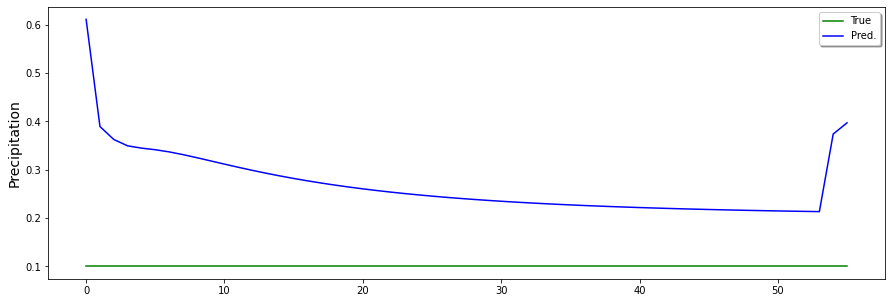

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 1512.9239501953125
MAE: 1.5129239559173584
RMSE: 2.76637601852417


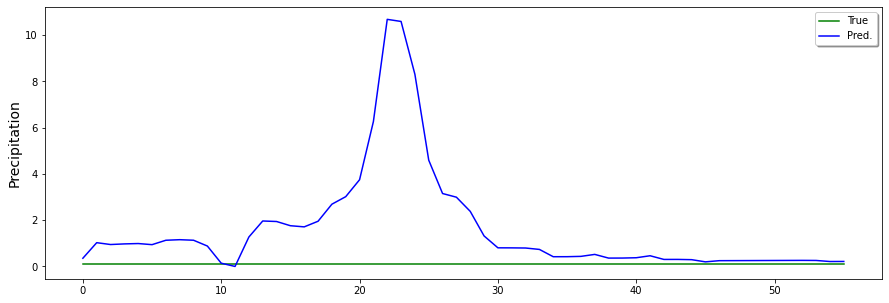

Start inference: general - Temperature
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 707.7399291992188
MAE: 6.905264377593994
RMSE: 7.974471092224121


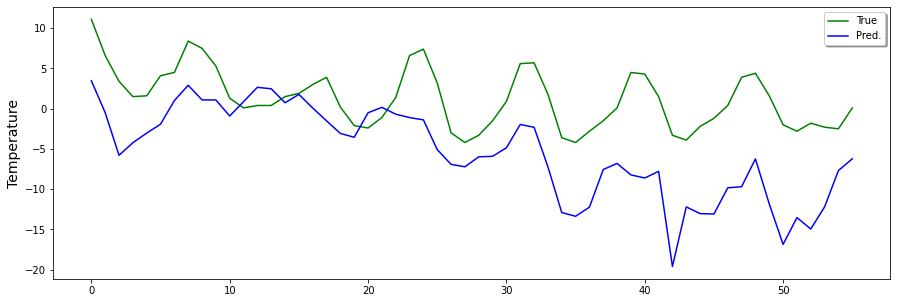

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 1296.6341552734375
MAE: 12.610090255737305
RMSE: 13.50327205657959


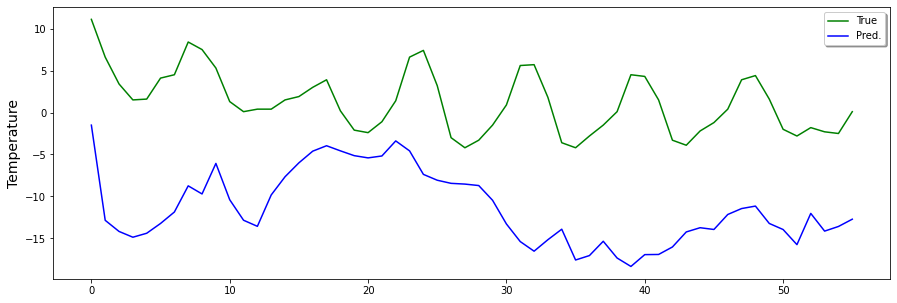

Start inference: general - Dew Point
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 515.3811645507812
MAE: 5.381351947784424
RMSE: 6.304871559143066


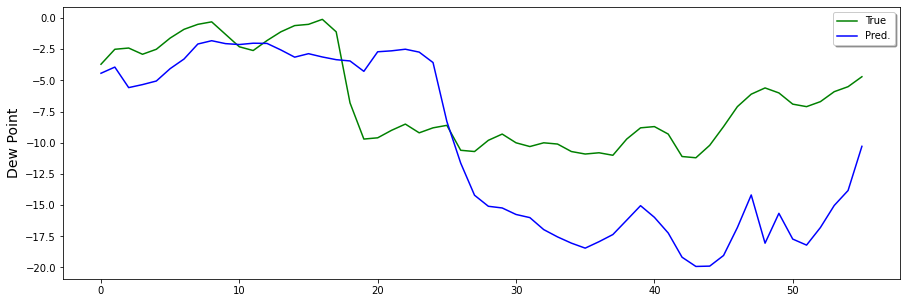

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 647.6845092773438
MAE: 7.507720470428467
RMSE: 8.522730827331543


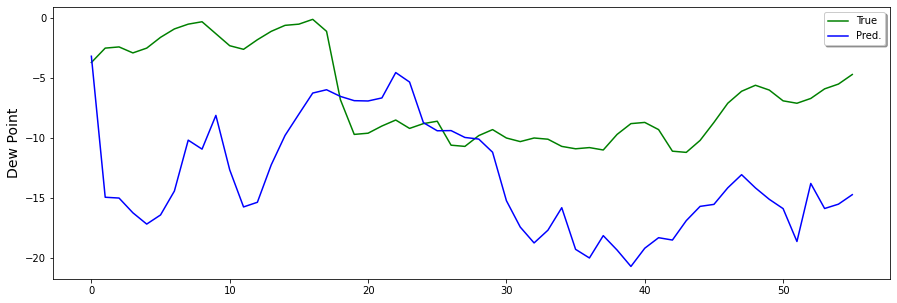

Start inference: general - Relative Humidity
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 40.72172164916992
MAE: 15.079815864562988
RMSE: 19.44054412841797


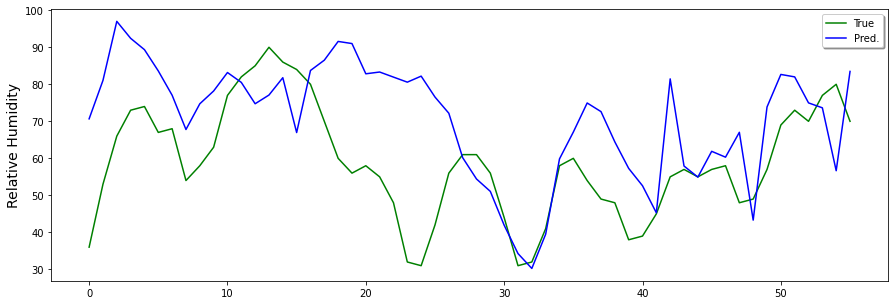

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 59.09872055053711
MAE: 28.332443237304688
RMSE: 32.15153503417969


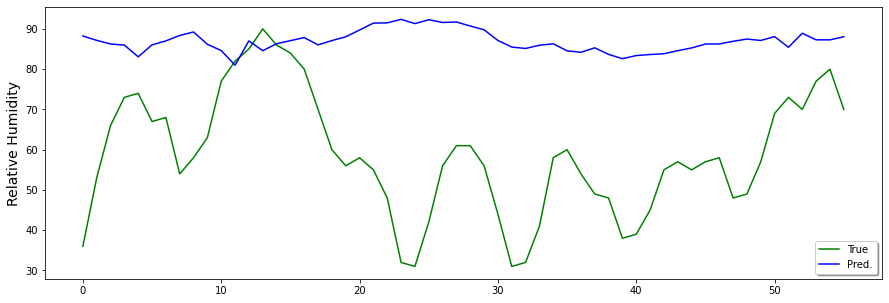

Start inference: general - Sea Level Pressure
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 0.9875151515007019
MAE: 7.44957971572876
RMSE: 8.394264221191406


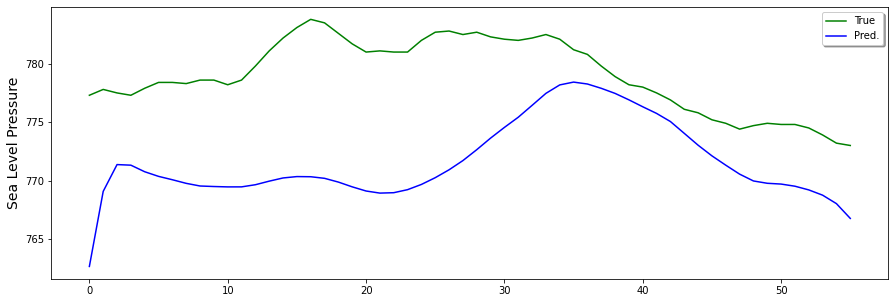

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 3.5108821392059326
MAE: 27.36275863647461
RMSE: 30.134937286376953


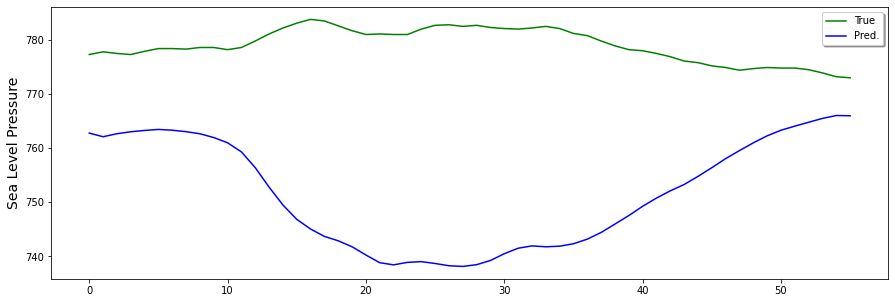

Start inference: general - Wind Speed
----------------------------
График для уменьшенной последовательности:
------------------------------------------
MAPE: 42.389434814453125
MAE: 1.1388450860977173
RMSE: 1.3669469356536865


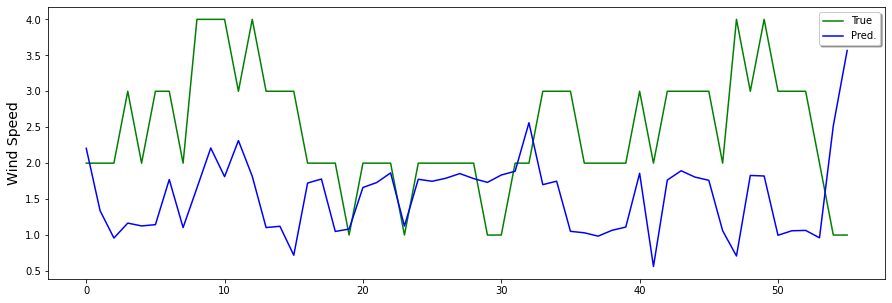

general
График для поэлементной последовательности:
-------------------------------------------
MAPE: 82.11176300048828
MAE: 1.5610681772232056
RMSE: 1.9291071891784668


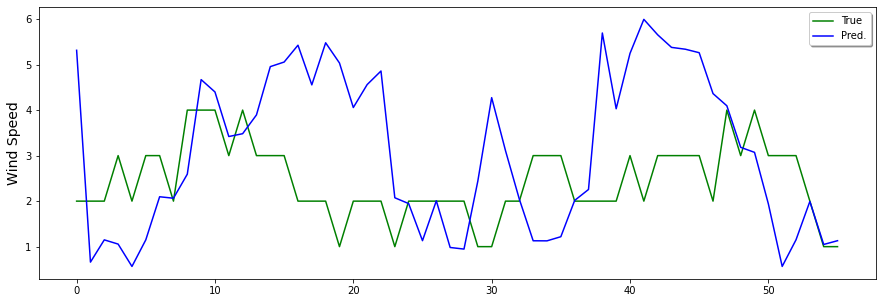

The end!
Расчет для региона: general
MAPE для Precipitation : 170.39480590820312 Точность: -70.39480590820312
RMSE для Precipitation : 0.18371714651584625 Точность: 0.36008560717105864
SMAPE для Precipitation : 89.17719843668435 Точность: 10.82280156331565
----------------------------------------------------------------
Расчет для региона: general
MAPE для Temperature : 584.8759765625 Точность: -484.8759765625
RMSE для Temperature : 7.974471092224121 Точность: 15.629963340759277
SMAPE для Temperature : 155.88727255244007 Точность: -55.887272552440066
----------------------------------------------------------------
Расчет для региона: general
MAPE для Dew Point : 166.43052673339844 Точность: -66.43052673339844
RMSE для Dew Point : 6.304871559143066 Точность: 12.35754825592041
SMAPE для Dew Point : 71.31399002705828 Точность: 28.68600997294172
----------------------------------------------------------------
Расчет для региона: general
MAPE для Relative Humidity : 29.664600372314453 Точно

In [56]:
if is_experiment:
    if is_experiment_interpolation_mape:
        for file in os.listdir(f'{experiment_dir}/{regions}'):
            if file.endswith('.csv'):
                if file[:-4] in elimination:
                    continue
                # Откроем один файл с данными и создадим проверочный набор
                date_test = pd.read_csv("experiment_dir/2016_cleane.csv", parse_dates = ['Date time'])
                # data_set = pd.read_csv(f'{experiment_dir}/{regions}/{file}') #, parse_dates = ['Date time'])
                last_time = date_test.iloc[0]['Date time']
                date_test = clearing_dataset(date_test)
                date_test = date_test.set_index('Date time')
                date_test = adjustment_for_mape(date_test)
                sq_df, pr_df = infer_models(date_test, single_y_scaler, f'{experiment_dir}/{save_dir}', file[:-4])
                for column in columns:
                    test_data = date_test.iloc[:56][[column]].values
                    pred_data = sq_df[[column]].values
                    mape = tf.keras.losses.MeanAbsolutePercentageError()
                    mape_column = mape(test_data, pred_data)
                    rmse= tf.keras.metrics.RootMeanSquaredError()
                    rmse_column = rmse(test_data, pred_data)
                    smape_column = smape(test_data, pred_data)
                    print('Расчет для региона:', file[:-4])
                    print('MAPE для', column, ':', float(mape_column), 'Точность:', 100-float(mape_column))
                    print('RMSE для', column, ':', float(rmse_column), 'Точность:', 1.96*float(rmse_column))
                    print('SMAPE для', column, ':', float(smape_column), 'Точность:', 100-float(smape_column))
                    print('----------------------------------------------------------------')